## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 65.6MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## 外れ値の検証

In [ ]:
!pip install category_encoders
!pip install optuna
!pip install pandas

     |████████████████████████████████| 82 kB 337 kB/s 
     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 80 kB 8.3 MB/s 
     |████████████████████████████████| 209 kB 40.4 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 112 kB 67.6 MB/s 
     |████████████████████████████████| 149 kB 60.1 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=e5b859f75734a3c081b5fc9b76de653b415533f62a3b4022935acd61a493a597
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


In [ ]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted 

import optuna.integration.lightgbm as lgb
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

from sklearn.ensemble import IsolationForest

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [ ]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

In [ ]:
# 欠損値補完直後のデータを対象
X_train_ff = X_train_ce.fillna(method='ffill')
X_test_ff = X_test_ce.fillna(method='ffill')

# IsolationForest はNaN非対応なので削除
X_train_dropna = X_train_ff.dropna(how="all", axis=1)
X_train_dropna = X_train_dropna.dropna(how="any", axis=0)

X_test_dropna = X_test_ff.dropna(how="all", axis=1)
X_test_dropna = X_test_dropna.dropna(how="any", axis=0)


# X の欠損行を削除したので、y もそれに合わせる
y_train = y_train.reset_index(drop=True)
y_train_dropna = y_train[y_train.index.isin(X_train_dropna.index)]

y_test = y_test.reset_index(drop=True)
y_test_dropna = y_test[y_test.index.isin(X_test_dropna.index)]

[I 2021-12-12 04:44:19,449] A new study created in memory with name: no-name-a277b08c-99c2-43b8-b636-7d99e02404ab
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.343539:  14%|#4        | 1/7 [00:00<00:02,  2.01it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.144723	Test's rmse: 0.343539
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.343539:  29%|##8       | 2/7 [00:00<00:02,  2.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12183	Test's rmse: 0.358725
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.343539:  43%|####2     | 3/7 [00:01<00:01,  2.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119178	Test's rmse: 0.359517
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.343539:  57%|#####7    | 4/7 [00:01<00:01,  2.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.109017	Test's rmse: 0.347243
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.343539:  71%|#######1  | 5/7 [00:02<00:00,  2.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110668	Test's rmse: 0.371135
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.343539:  86%|########5 | 6/7 [00:02<00:00,  2.25it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111333	Test's rmse: 0.349154
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.343539: 100%|##########| 7/7 [00:03<00:00,  2.31it/s]


Early stopping, best iteration is:
[34]	Train's rmse: 0.153648	Test's rmse: 0.345486


num_leaves, val_score: 0.343539:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343539:   5%|5         | 1/20 [00:01<00:20,  1.09s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124945	Test's rmse: 0.343982
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343539:  10%|#         | 2/20 [00:01<00:14,  1.24it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125665	Test's rmse: 0.346007
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343539:  15%|#5        | 3/20 [00:03<00:19,  1.15s/it]

Early stopping, best iteration is:
[47]	Train's rmse: 0.145841	Test's rmse: 0.345426
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343539:  20%|##        | 4/20 [00:04<00:19,  1.20s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126277	Test's rmse: 0.344566
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343539:  25%|##5       | 5/20 [00:05<00:17,  1.15s/it]

Early stopping, best iteration is:
[47]	Train's rmse: 0.147156	Test's rmse: 0.345092
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.343539:  30%|###       | 6/20 [00:06<00:14,  1.05s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127539	Test's rmse: 0.345084
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.342138:  35%|###5      | 7/20 [00:06<00:10,  1.21it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.144429	Test's rmse: 0.342138
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.342138:  40%|####      | 8/20 [00:07<00:10,  1.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125012	Test's rmse: 0.346377
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.342138:  45%|####5     | 9/20 [00:09<00:12,  1.14s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125911	Test's rmse: 0.345451
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.342138:  50%|#####     | 10/20 [00:11<00:13,  1.31s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125708	Test's rmse: 0.342865
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.342138:  55%|#####5    | 11/20 [00:11<00:08,  1.01it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.151593	Test's rmse: 0.344367
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.341209:  60%|######    | 12/20 [00:12<00:09,  1.13s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123702	Test's rmse: 0.341209
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.341209:  65%|######5   | 13/20 [00:14<00:08,  1.20s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.145021	Test's rmse: 0.345883
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.341209:  70%|#######   | 14/20 [00:16<00:08,  1.43s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127094	Test's rmse: 0.344152
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.341209:  75%|#######5  | 15/20 [00:17<00:07,  1.46s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126462	Test's rmse: 0.34536
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.341209:  80%|########  | 16/20 [00:18<00:04,  1.09s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127132	Test's rmse: 0.346603
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.341209:  85%|########5 | 17/20 [00:18<00:02,  1.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123326	Test's rmse: 0.344727
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.341209:  90%|######### | 18/20 [00:19<00:02,  1.08s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126118	Test's rmse: 0.342457
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.341209:  95%|#########5| 19/20 [00:20<00:01,  1.03s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12524	Test's rmse: 0.343219
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.341209: 100%|##########| 20/20 [00:22<00:00,  1.14s/it]


Early stopping, best iteration is:
[47]	Train's rmse: 0.145912	Test's rmse: 0.345255


bagging, val_score: 0.341209:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.326505:  10%|#         | 1/10 [00:01<00:14,  1.61s/it]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.149947	Test's rmse: 0.326505
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.323837:  20%|##        | 2/10 [00:03<00:12,  1.53s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160867	Test's rmse: 0.323837
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.323837:  30%|###       | 3/10 [00:04<00:11,  1.59s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130582	Test's rmse: 0.339098
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.323837:  40%|####      | 4/10 [00:06<00:09,  1.57s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153174	Test's rmse: 0.330002
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.323837:  50%|#####     | 5/10 [00:07<00:07,  1.55s/it]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.158088	Test's rmse: 0.335665
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.323837:  60%|######    | 6/10 [00:09<00:06,  1.60s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139146	Test's rmse: 0.338304
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.323837:  70%|#######   | 7/10 [00:11<00:04,  1.57s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150143	Test's rmse: 0.330156
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.323837:  80%|########  | 8/10 [00:12<00:03,  1.57s/it]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.157158	Test's rmse: 0.327751
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.323837:  90%|######### | 9/10 [00:14<00:01,  1.56s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.156727	Test's rmse: 0.327522
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.323837: 100%|##########| 10/10 [00:15<00:00,  1.56s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161925	Test's rmse: 0.332969


feature_fraction_stage2, val_score: 0.323837:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.323117:  17%|#6        | 1/6 [00:01<00:07,  1.48s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160314	Test's rmse: 0.323117
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.323117:  33%|###3      | 2/6 [00:02<00:05,  1.42s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155757	Test's rmse: 0.336304
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.323117:  50%|#####     | 3/6 [00:04<00:04,  1.41s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157285	Test's rmse: 0.33577
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.323117:  67%|######6   | 4/6 [00:05<00:02,  1.42s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160867	Test's rmse: 0.323837
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.323117:  83%|########3 | 5/6 [00:07<00:01,  1.42s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160867	Test's rmse: 0.323837
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.323117: 100%|##########| 6/6 [00:08<00:00,  1.42s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157285	Test's rmse: 0.33577


regularization_factors, val_score: 0.323117:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:   5%|5         | 1/20 [00:01<00:28,  1.48s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162461	Test's rmse: 0.322228
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  10%|#         | 2/20 [00:02<00:26,  1.47s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159859	Test's rmse: 0.323388
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  15%|#5        | 3/20 [00:04<00:25,  1.49s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159892	Test's rmse: 0.323573
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  20%|##        | 4/20 [00:05<00:24,  1.50s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160336	Test's rmse: 0.322967
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  25%|##5       | 5/20 [00:06<00:19,  1.32s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160898	Test's rmse: 0.322722
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  30%|###       | 6/20 [00:08<00:18,  1.30s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162555	Test's rmse: 0.324874
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  35%|###5      | 7/20 [00:09<00:17,  1.34s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162589	Test's rmse: 0.324031
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  40%|####      | 8/20 [00:11<00:16,  1.39s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159824	Test's rmse: 0.323191
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  45%|####5     | 9/20 [00:12<00:15,  1.40s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160393	Test's rmse: 0.323442
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  50%|#####     | 10/20 [00:14<00:14,  1.40s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160068	Test's rmse: 0.322972
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  55%|#####5    | 11/20 [00:14<00:10,  1.12s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162724	Test's rmse: 0.329193
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  60%|######    | 12/20 [00:14<00:07,  1.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162636	Test's rmse: 0.336536
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  65%|######5   | 13/20 [00:15<00:06,  1.08it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160796	Test's rmse: 0.324782
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  70%|#######   | 14/20 [00:17<00:06,  1.03s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162552	Test's rmse: 0.326971
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  75%|#######5  | 15/20 [00:18<00:05,  1.05s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160585	Test's rmse: 0.324221
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322228:  80%|########  | 16/20 [00:19<00:04,  1.14s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160616	Test's rmse: 0.323125
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322038:  85%|########5 | 17/20 [00:20<00:03,  1.22s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162898	Test's rmse: 0.322038
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322038:  90%|######### | 18/20 [00:22<00:02,  1.28s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162935	Test's rmse: 0.32378
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.322038:  95%|#########5| 19/20 [00:23<00:01,  1.26s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164841	Test's rmse: 0.327684
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.321838: 100%|##########| 20/20 [00:25<00:00,  1.25s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162644	Test's rmse: 0.321838


min_data_in_leaf, val_score: 0.321838:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.321838:  20%|##        | 1/5 [00:01<00:06,  1.55s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0621824	Test's rmse: 0.367379
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.321838:  40%|####      | 2/5 [00:03<00:04,  1.57s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.116435	Test's rmse: 0.343135
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.321838:  60%|######    | 3/5 [00:04<00:03,  1.52s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16485	Test's rmse: 0.33323
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.321838:  80%|########  | 4/5 [00:05<00:01,  1.30s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.231355	Test's rmse: 0.382691
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.321838: 100%|##########| 5/5 [00:06<00:00,  1.26s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.304124	Test's rmse: 0.456849


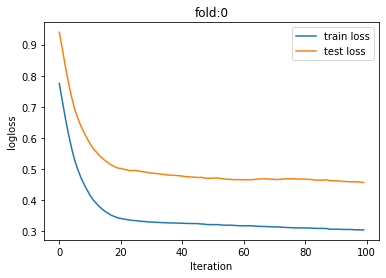

[I 2021-12-12 04:45:40,982] A new study created in memory with name: no-name-7aa3805a-4e25-41f1-82aa-4ab92db25480
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.108350:  14%|#4        | 1/7 [00:00<00:02,  2.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130029	Test's rmse: 0.10835
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.108350:  29%|##8       | 2/7 [00:00<00:02,  2.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137295	Test's rmse: 0.145639
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.108350:  43%|####2     | 3/7 [00:01<00:01,  2.16it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15304	Test's rmse: 0.112563
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.108350:  57%|#####7    | 4/7 [00:01<00:01,  2.08it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147057	Test's rmse: 0.111786
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.108350:  71%|#######1  | 5/7 [00:02<00:00,  2.30it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137253	Test's rmse: 0.138702
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.108350:  86%|########5 | 6/7 [00:02<00:00,  2.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131906	Test's rmse: 0.112057
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.108350: 100%|##########| 7/7 [00:03<00:00,  2.22it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131736	Test's rmse: 0.123441


num_leaves, val_score: 0.108350:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.108350:   5%|5         | 1/20 [00:01<00:30,  1.58s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138872	Test's rmse: 0.117485


num_leaves, val_score: 0.108350:  10%|#         | 2/20 [00:01<00:14,  1.26it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137677	Test's rmse: 0.114844
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.108350:  15%|#5        | 3/20 [00:02<00:15,  1.07it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130997	Test's rmse: 0.113921
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.108350:  20%|##        | 4/20 [00:04<00:20,  1.29s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133411	Test's rmse: 0.117078
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  25%|##5       | 5/20 [00:05<00:15,  1.00s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132706	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  30%|###       | 6/20 [00:07<00:17,  1.26s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137883	Test's rmse: 0.116849
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  35%|###5      | 7/20 [00:07<00:12,  1.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132634	Test's rmse: 0.104466
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  40%|####      | 8/20 [00:08<00:13,  1.12s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1351	Test's rmse: 0.114717
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  45%|####5     | 9/20 [00:09<00:11,  1.09s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135484	Test's rmse: 0.112001
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  50%|#####     | 10/20 [00:11<00:11,  1.19s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130065	Test's rmse: 0.116195
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  55%|#####5    | 11/20 [00:11<00:09,  1.03s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131502	Test's rmse: 0.104647
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  60%|######    | 12/20 [00:12<00:06,  1.27it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137677	Test's rmse: 0.114844
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  65%|######5   | 13/20 [00:12<00:05,  1.31it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137836	Test's rmse: 0.110852
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  70%|#######   | 14/20 [00:13<00:04,  1.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132206	Test's rmse: 0.105405
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  75%|#######5  | 15/20 [00:14<00:03,  1.51it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133471	Test's rmse: 0.10209
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  80%|########  | 16/20 [00:14<00:02,  1.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137263	Test's rmse: 0.112596
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  85%|########5 | 17/20 [00:15<00:01,  1.54it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131643	Test's rmse: 0.104853
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  90%|######### | 18/20 [00:16<00:01,  1.22it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133623	Test's rmse: 0.112562
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656:  95%|#########5| 19/20 [00:17<00:00,  1.20it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137331	Test's rmse: 0.110278
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101656: 100%|##########| 20/20 [00:17<00:00,  1.11it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130029	Test's rmse: 0.10835


bagging, val_score: 0.101656:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101656:  10%|#         | 1/10 [00:00<00:04,  1.90it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17242	Test's rmse: 0.119323
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101656:  20%|##        | 2/10 [00:01<00:04,  1.85it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.199067	Test's rmse: 0.132172
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101656:  30%|###       | 3/10 [00:01<00:03,  1.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172596	Test's rmse: 0.116911
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101656:  40%|####      | 4/10 [00:02<00:03,  1.81it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167338	Test's rmse: 0.118424
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101656:  50%|#####     | 5/10 [00:02<00:02,  1.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.179125	Test's rmse: 0.122631
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101656:  60%|######    | 6/10 [00:03<00:02,  1.77it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159921	Test's rmse: 0.119371
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101656:  70%|#######   | 7/10 [00:03<00:01,  1.79it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1602	Test's rmse: 0.118351
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101656:  80%|########  | 8/10 [00:04<00:01,  1.78it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17623	Test's rmse: 0.120018
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101656:  90%|######### | 9/10 [00:05<00:00,  1.79it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174495	Test's rmse: 0.118748
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101656: 100%|##########| 10/10 [00:05<00:00,  1.78it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164571	Test's rmse: 0.118044


feature_fraction_stage2, val_score: 0.101656:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.101656:  17%|#6        | 1/6 [00:00<00:02,  2.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128194	Test's rmse: 0.110729
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.101656:  33%|###3      | 2/6 [00:00<00:01,  2.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13206	Test's rmse: 0.110951
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.101656:  50%|#####     | 3/6 [00:01<00:01,  1.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13602	Test's rmse: 0.107763
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.101656:  67%|######6   | 4/6 [00:02<00:01,  1.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132706	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.101656:  83%|########3 | 5/6 [00:02<00:00,  1.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132706	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.101656: 100%|##########| 6/6 [00:03<00:00,  1.97it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13206	Test's rmse: 0.110951


regularization_factors, val_score: 0.101656:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:   5%|5         | 1/20 [00:00<00:09,  2.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130071	Test's rmse: 0.108285
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  10%|#         | 2/20 [00:00<00:08,  2.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139824	Test's rmse: 0.110047
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  15%|#5        | 3/20 [00:01<00:08,  2.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128428	Test's rmse: 0.114892
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  20%|##        | 4/20 [00:01<00:07,  2.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129791	Test's rmse: 0.108239
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  25%|##5       | 5/20 [00:02<00:07,  2.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133644	Test's rmse: 0.101762
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  30%|###       | 6/20 [00:02<00:06,  2.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131779	Test's rmse: 0.102972
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  35%|###5      | 7/20 [00:03<00:06,  2.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133408	Test's rmse: 0.108193
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  40%|####      | 8/20 [00:03<00:06,  1.99it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132707	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  45%|####5     | 9/20 [00:04<00:05,  1.99it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132707	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  50%|#####     | 10/20 [00:04<00:04,  2.00it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137955	Test's rmse: 0.109588
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  55%|#####5    | 11/20 [00:05<00:04,  1.98it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129472	Test's rmse: 0.102071
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  60%|######    | 12/20 [00:06<00:04,  1.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132707	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  65%|######5   | 13/20 [00:06<00:03,  1.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132707	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  70%|#######   | 14/20 [00:07<00:03,  1.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132706	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  75%|#######5  | 15/20 [00:07<00:02,  1.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132706	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  80%|########  | 16/20 [00:08<00:02,  1.94it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132706	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  85%|########5 | 17/20 [00:08<00:01,  1.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132706	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  90%|######### | 18/20 [00:09<00:01,  1.93it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132706	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656:  95%|#########5| 19/20 [00:09<00:00,  1.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132706	Test's rmse: 0.101656
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101656: 100%|##########| 20/20 [00:10<00:00,  1.97it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132706	Test's rmse: 0.101656


min_data_in_leaf, val_score: 0.101656:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.101656:  20%|##        | 1/5 [00:00<00:01,  2.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0667802	Test's rmse: 0.10724
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.101656:  40%|####      | 2/5 [00:01<00:01,  1.87it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.241046	Test's rmse: 0.186942
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.101656:  60%|######    | 3/5 [00:01<00:00,  2.06it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0744758	Test's rmse: 0.124655
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.101656:  80%|########  | 4/5 [00:02<00:00,  1.99it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155164	Test's rmse: 0.116057
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.101656: 100%|##########| 5/5 [00:02<00:00,  2.07it/s]

Early stopping, best iteration is:
[24]	Train's rmse: 0.336896	Test's rmse: 0.231378


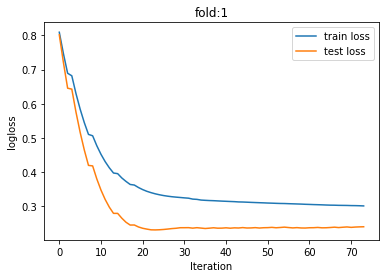

[I 2021-12-12 04:46:23,611] A new study created in memory with name: no-name-a496f1e3-e57b-47e1-84f8-4947a1f9a7d3
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.168572:  14%|#4        | 1/7 [00:00<00:02,  2.80it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142131	Test's rmse: 0.168572
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.147106:  29%|##8       | 2/7 [00:00<00:02,  2.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125099	Test's rmse: 0.147106
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.143310:  43%|####2     | 3/7 [00:01<00:01,  2.24it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125483	Test's rmse: 0.14331
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139944:  57%|#####7    | 4/7 [00:01<00:01,  2.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13843	Test's rmse: 0.139944
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139944:  71%|#######1  | 5/7 [00:02<00:00,  2.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131589	Test's rmse: 0.15724
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139944:  86%|########5 | 6/7 [00:02<00:00,  2.16it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14364	Test's rmse: 0.14255
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139944: 100%|##########| 7/7 [00:03<00:00,  2.23it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126301	Test's rmse: 0.146021


num_leaves, val_score: 0.139944:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:   5%|5         | 1/20 [00:00<00:07,  2.57it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143598	Test's rmse: 0.140831
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  10%|#         | 2/20 [00:01<00:14,  1.20it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138509	Test's rmse: 0.14438
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  15%|#5        | 3/20 [00:03<00:20,  1.19s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137629	Test's rmse: 0.143622
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  20%|##        | 4/20 [00:03<00:14,  1.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141416	Test's rmse: 0.141178
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  25%|##5       | 5/20 [00:05<00:18,  1.23s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136784	Test's rmse: 0.140767
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  30%|###       | 6/20 [00:06<00:18,  1.32s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137678	Test's rmse: 0.143124
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  35%|###5      | 7/20 [00:08<00:16,  1.24s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138838	Test's rmse: 0.142832
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  40%|####      | 8/20 [00:08<00:11,  1.08it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140501	Test's rmse: 0.149502
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  45%|####5     | 9/20 [00:08<00:08,  1.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141416	Test's rmse: 0.141178
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  50%|#####     | 10/20 [00:09<00:08,  1.20it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14378	Test's rmse: 0.142956
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  55%|#####5    | 11/20 [00:11<00:10,  1.20s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135255	Test's rmse: 0.146512
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  60%|######    | 12/20 [00:13<00:11,  1.42s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137367	Test's rmse: 0.140762
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  65%|######5   | 13/20 [00:15<00:10,  1.55s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136284	Test's rmse: 0.142265
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  70%|#######   | 14/20 [00:17<00:09,  1.60s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139467	Test's rmse: 0.143136
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  75%|#######5  | 15/20 [00:19<00:08,  1.75s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139185	Test's rmse: 0.143868
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  80%|########  | 16/20 [00:21<00:07,  1.76s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137439	Test's rmse: 0.142729
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  85%|########5 | 17/20 [00:22<00:05,  1.68s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136048	Test's rmse: 0.143661
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  90%|######### | 18/20 [00:24<00:03,  1.74s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137322	Test's rmse: 0.144997
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944:  95%|#########5| 19/20 [00:26<00:01,  1.71s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138326	Test's rmse: 0.140333
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139944: 100%|##########| 20/20 [00:26<00:00,  1.34s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13937	Test's rmse: 0.139962


bagging, val_score: 0.139944:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139944:  10%|#         | 1/10 [00:00<00:05,  1.78it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.186872	Test's rmse: 0.152122
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139944:  20%|##        | 2/10 [00:01<00:04,  1.81it/s]

Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.176611	Test's rmse: 0.149549
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139944:  30%|###       | 3/10 [00:01<00:03,  1.79it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.186024	Test's rmse: 0.150985
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139944:  40%|####      | 4/10 [00:02<00:03,  1.88it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.209687	Test's rmse: 0.159539
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139944:  50%|#####     | 5/10 [00:02<00:02,  1.86it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17494	Test's rmse: 0.151205
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139944:  60%|######    | 6/10 [00:03<00:02,  1.81it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171398	Test's rmse: 0.150643
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139944:  70%|#######   | 7/10 [00:03<00:01,  1.80it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153967	Test's rmse: 0.151028
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139944:  80%|########  | 8/10 [00:04<00:01,  1.79it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154625	Test's rmse: 0.14987
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139944:  90%|######### | 9/10 [00:04<00:00,  1.81it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176038	Test's rmse: 0.153425
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139944: 100%|##########| 10/10 [00:05<00:00,  1.82it/s]


Early stopping, best iteration is:
[41]	Train's rmse: 0.20998	Test's rmse: 0.166116


feature_fraction_stage2, val_score: 0.139944:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.139944:  17%|#6        | 1/6 [00:00<00:02,  1.98it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13843	Test's rmse: 0.139944
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.139944:  33%|###3      | 2/6 [00:01<00:02,  2.00it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125483	Test's rmse: 0.14331
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.138598:  50%|#####     | 3/6 [00:01<00:01,  1.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141025	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.138598:  67%|######6   | 4/6 [00:02<00:01,  1.92it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141025	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.138598:  83%|########3 | 5/6 [00:02<00:00,  1.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129138	Test's rmse: 0.139079
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.138598: 100%|##########| 6/6 [00:03<00:00,  1.93it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129138	Test's rmse: 0.139079


regularization_factors, val_score: 0.138598:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:   5%|5         | 1/20 [00:00<00:10,  1.87it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142575	Test's rmse: 0.140622
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  10%|#         | 2/20 [00:01<00:09,  1.89it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141026	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  15%|#5        | 3/20 [00:01<00:08,  2.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139138	Test's rmse: 0.154573
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  20%|##        | 4/20 [00:02<00:07,  2.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146965	Test's rmse: 0.139919
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  25%|##5       | 5/20 [00:02<00:07,  2.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135664	Test's rmse: 0.152818
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  30%|###       | 6/20 [00:02<00:06,  2.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152824	Test's rmse: 0.143182
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  35%|###5      | 7/20 [00:03<00:06,  1.98it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141026	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  40%|####      | 8/20 [00:04<00:06,  1.94it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14279	Test's rmse: 0.141182
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  45%|####5     | 9/20 [00:04<00:05,  1.94it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141026	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  50%|#####     | 10/20 [00:05<00:05,  1.93it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149448	Test's rmse: 0.146064
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  55%|#####5    | 11/20 [00:05<00:04,  1.94it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141026	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  60%|######    | 12/20 [00:06<00:04,  1.92it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141026	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  65%|######5   | 13/20 [00:06<00:03,  1.92it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141025	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  70%|#######   | 14/20 [00:07<00:03,  1.87it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141025	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  75%|#######5  | 15/20 [00:07<00:02,  1.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141025	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  80%|########  | 16/20 [00:08<00:02,  1.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141026	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  85%|########5 | 17/20 [00:08<00:01,  1.80it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142715	Test's rmse: 0.140959
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  90%|######### | 18/20 [00:09<00:01,  1.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141026	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598:  95%|#########5| 19/20 [00:09<00:00,  1.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141026	Test's rmse: 0.138598
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.138598: 100%|##########| 20/20 [00:10<00:00,  1.91it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141026	Test's rmse: 0.138598


min_data_in_leaf, val_score: 0.138598:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.138598:  20%|##        | 1/5 [00:00<00:01,  2.19it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.0849283	Test's rmse: 0.143101
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.138598:  40%|####      | 2/5 [00:00<00:01,  2.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0671526	Test's rmse: 0.148943
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.138598:  60%|######    | 3/5 [00:01<00:01,  1.93it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.289164	Test's rmse: 0.193799
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.138598:  80%|########  | 4/5 [00:02<00:00,  1.90it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159212	Test's rmse: 0.150015
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.138598: 100%|##########| 5/5 [00:02<00:00,  1.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.23942	Test's rmse: 0.168768


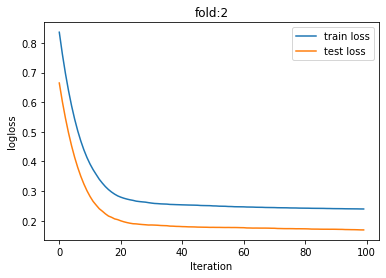

[I 2021-12-12 04:47:15,673] A new study created in memory with name: no-name-48086bd3-3571-4196-86d3-f0b580e666cf
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107101:  14%|#4        | 1/7 [00:00<00:02,  2.78it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143185	Test's rmse: 0.107101
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.081809:  29%|##8       | 2/7 [00:00<00:02,  2.42it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13093	Test's rmse: 0.0818085
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.081809:  43%|####2     | 3/7 [00:01<00:01,  2.49it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140062	Test's rmse: 0.10077
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.021516:  57%|#####7    | 4/7 [00:01<00:01,  2.29it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.171356	Test's rmse: 0.021516
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.021516:  71%|#######1  | 5/7 [00:02<00:00,  2.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133649	Test's rmse: 0.0523821
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.021516:  86%|########5 | 6/7 [00:02<00:00,  2.12it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.167152	Test's rmse: 0.0333657
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.021516: 100%|##########| 7/7 [00:03<00:00,  2.23it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13262	Test's rmse: 0.071085


num_leaves, val_score: 0.021516:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021516:   5%|5         | 1/20 [00:00<00:13,  1.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155422	Test's rmse: 0.0288989
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021516:  10%|#         | 2/20 [00:02<00:22,  1.26s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154217	Test's rmse: 0.0301904
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021516:  15%|#5        | 3/20 [00:03<00:20,  1.18s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154417	Test's rmse: 0.0295837
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021516:  20%|##        | 4/20 [00:04<00:16,  1.05s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154245	Test's rmse: 0.029392
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021516:  25%|##5       | 5/20 [00:05<00:18,  1.23s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15424	Test's rmse: 0.0303706
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021272:  30%|###       | 6/20 [00:07<00:19,  1.39s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.168059	Test's rmse: 0.0212724
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021272:  35%|###5      | 7/20 [00:09<00:19,  1.49s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154281	Test's rmse: 0.0300739
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.021272:  40%|####      | 8/20 [00:10<00:17,  1.47s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15431	Test's rmse: 0.0301487
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.019685:  45%|####5     | 9/20 [00:11<00:12,  1.13s/it]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.019685:  55%|#####5    | 11/20 [00:11<00:06,  1.49it/s][I 2021-12-12 04:47:30,419] Trial 17 finished with value: 0.04773155678898923 and parameters: {'num_leaves': 2}. Best is trial 15 with value: 0.019684537999709005.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15349	Test's rmse: 0.0276003
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.209101	Test's rmse: 0.0477316


num_leaves, val_score: 0.019685:  55%|#####5    | 11/20 [00:11<00:06,  1.49it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.019685:  60%|######    | 12/20 [00:13<00:08,  1.09s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154124	Test's rmse: 0.0300298
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.019685:  65%|######5   | 13/20 [00:15<00:09,  1.38s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154251	Test's rmse: 0.0297185
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.019685:  70%|#######   | 14/20 [00:16<00:07,  1.32s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154285	Test's rmse: 0.0302644
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.019685:  75%|#######5  | 15/20 [00:18<00:07,  1.42s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.168059	Test's rmse: 0.0212739
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.019685:  80%|########  | 16/20 [00:19<00:05,  1.41s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15424	Test's rmse: 0.0305947
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.019685:  85%|########5 | 17/20 [00:20<00:03,  1.17s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.169627	Test's rmse: 0.0204928
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.019685:  90%|######### | 18/20 [00:21<00:01,  1.01it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.170438	Test's rmse: 0.0198375
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.019685:  95%|#########5| 19/20 [00:21<00:00,  1.04it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.168616	Test's rmse: 0.021482
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.019685: 100%|##########| 20/20 [00:22<00:00,  1.12s/it]


Early stopping, best iteration is:
[47]	Train's rmse: 0.167305	Test's rmse: 0.0221997


bagging, val_score: 0.019685:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.019685:  10%|#         | 1/10 [00:00<00:03,  2.25it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.184361	Test's rmse: 0.0334776
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.019685:  20%|##        | 2/10 [00:00<00:03,  2.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15397	Test's rmse: 0.0276303
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.019685:  30%|###       | 3/10 [00:01<00:03,  2.26it/s]

Did not meet early stopping. Best iteration is:
[94]	Train's rmse: 0.18761	Test's rmse: 0.034507
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.019685:  40%|####      | 4/10 [00:01<00:02,  2.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182214	Test's rmse: 0.0320757
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.019685:  50%|#####     | 5/10 [00:02<00:02,  2.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.18062	Test's rmse: 0.029378
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.019685:  60%|######    | 6/10 [00:02<00:01,  2.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.192488	Test's rmse: 0.0373175
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.019685:  70%|#######   | 7/10 [00:03<00:01,  2.33it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.190017	Test's rmse: 0.0369128
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.019685:  80%|########  | 8/10 [00:03<00:00,  2.33it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181744	Test's rmse: 0.0233676
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.019685:  90%|######### | 9/10 [00:03<00:00,  2.29it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.183867	Test's rmse: 0.0298578
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.019685: 100%|##########| 10/10 [00:04<00:00,  2.29it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161908	Test's rmse: 0.0258289


feature_fraction_stage2, val_score: 0.019685:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.019685:  33%|###3      | 1/3 [00:00<00:00,  2.59it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.170694	Test's rmse: 0.0322743
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.019685:  67%|######6   | 2/3 [00:00<00:00,  2.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156936	Test's rmse: 0.0387146
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.019685: 100%|##########| 3/3 [00:01<00:00,  2.53it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156936	Test's rmse: 0.0387146


regularization_factors, val_score: 0.019685:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:   5%|5         | 1/20 [00:00<00:07,  2.55it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.17174	Test's rmse: 0.022155
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  10%|#         | 2/20 [00:00<00:06,  2.74it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.172066	Test's rmse: 0.0203702
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  15%|#5        | 3/20 [00:01<00:06,  2.82it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.168258	Test's rmse: 0.0211563
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  20%|##        | 4/20 [00:01<00:05,  2.72it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  25%|##5       | 5/20 [00:01<00:05,  2.71it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.169641	Test's rmse: 0.0209454
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  30%|###       | 6/20 [00:02<00:05,  2.62it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15466	Test's rmse: 0.0283183
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  35%|###5      | 7/20 [00:02<00:04,  2.65it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.169896	Test's rmse: 0.0226098
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  40%|####      | 8/20 [00:02<00:04,  2.71it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.174196	Test's rmse: 0.0207869
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  45%|####5     | 9/20 [00:03<00:04,  2.70it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.17174	Test's rmse: 0.0221551
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  50%|#####     | 10/20 [00:03<00:03,  2.66it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143954	Test's rmse: 0.0314397
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  55%|#####5    | 11/20 [00:04<00:03,  2.65it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  60%|######    | 12/20 [00:04<00:03,  2.60it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  65%|######5   | 13/20 [00:04<00:02,  2.59it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  70%|#######   | 14/20 [00:05<00:02,  2.59it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.173481	Test's rmse: 0.0200561
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  75%|#######5  | 15/20 [00:05<00:01,  2.61it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  80%|########  | 16/20 [00:06<00:01,  2.62it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196846
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  85%|########5 | 17/20 [00:06<00:01,  2.65it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.168642	Test's rmse: 0.0205112
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  90%|######### | 18/20 [00:06<00:00,  2.61it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196846
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685:  95%|#########5| 19/20 [00:07<00:00,  2.64it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.168585	Test's rmse: 0.0196845
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.019685: 100%|##########| 20/20 [00:07<00:00,  2.64it/s]


Early stopping, best iteration is:
[46]	Train's rmse: 0.168639	Test's rmse: 0.020512


min_data_in_leaf, val_score: 0.019685:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.019685:  20%|##        | 1/5 [00:00<00:01,  2.82it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.107189	Test's rmse: 0.0241533
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.019685:  40%|####      | 2/5 [00:00<00:01,  2.63it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.258625	Test's rmse: 0.0565003
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.019685:  60%|######    | 3/5 [00:01<00:00,  2.74it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.320872	Test's rmse: 0.0921468
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.019685:  80%|########  | 4/5 [00:01<00:00,  2.78it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.0507692	Test's rmse: 0.0266891
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.019685: 100%|##########| 5/5 [00:01<00:00,  2.71it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.180084	Test's rmse: 0.0304209


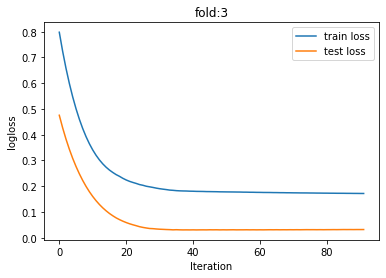

[I 2021-12-12 04:47:56,553] A new study created in memory with name: no-name-cdc7a4ff-8ff3-4214-abe1-248c1cbcbdb7
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.378627:  14%|#4        | 1/7 [00:00<00:02,  2.29it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.156697	Test's rmse: 0.378627
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.361661:  29%|##8       | 2/7 [00:00<00:02,  2.19it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.155527	Test's rmse: 0.361661
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.361661:  43%|####2     | 3/7 [00:01<00:01,  2.24it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124112	Test's rmse: 0.407915
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.361661:  57%|#####7    | 4/7 [00:01<00:01,  2.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.118338	Test's rmse: 0.390241
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.361661:  71%|#######1  | 5/7 [00:02<00:00,  2.15it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123143	Test's rmse: 0.389641
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.361661:  86%|########5 | 6/7 [00:02<00:00,  2.15it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.160637	Test's rmse: 0.367796
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.361661: 100%|##########| 7/7 [00:03<00:00,  2.21it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125349	Test's rmse: 0.409931


num_leaves, val_score: 0.361661:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358102:   5%|5         | 1/20 [00:01<00:25,  1.33s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158494	Test's rmse: 0.358102
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358102:  10%|#         | 2/20 [00:02<00:19,  1.10s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158672	Test's rmse: 0.358497
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  15%|#5        | 3/20 [00:03<00:18,  1.09s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158495	Test's rmse: 0.358099
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  20%|##        | 4/20 [00:04<00:18,  1.13s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158495	Test's rmse: 0.358101
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  25%|##5       | 5/20 [00:05<00:18,  1.21s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158493	Test's rmse: 0.358102
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  30%|###       | 6/20 [00:06<00:15,  1.09s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158672	Test's rmse: 0.358498
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  35%|###5      | 7/20 [00:08<00:16,  1.27s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158493	Test's rmse: 0.358102
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  40%|####      | 8/20 [00:09<00:14,  1.21s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.15867	Test's rmse: 0.358496
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  45%|####5     | 9/20 [00:10<00:11,  1.07s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158694	Test's rmse: 0.358475
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  50%|#####     | 10/20 [00:11<00:11,  1.13s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158494	Test's rmse: 0.358102
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  55%|#####5    | 11/20 [00:11<00:08,  1.08it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.155528	Test's rmse: 0.362207
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  60%|######    | 12/20 [00:13<00:07,  1.02it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158496	Test's rmse: 0.3581
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  65%|######5   | 13/20 [00:13<00:05,  1.18it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158175	Test's rmse: 0.35927
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  70%|#######   | 14/20 [00:14<00:05,  1.10it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158686	Test's rmse: 0.358482
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  75%|#######5  | 15/20 [00:16<00:05,  1.10s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158493	Test's rmse: 0.358102
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  80%|########  | 16/20 [00:16<00:03,  1.02it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.160691	Test's rmse: 0.35872
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  85%|########5 | 17/20 [00:18<00:03,  1.04s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158685	Test's rmse: 0.358483
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.358099:  90%|######### | 18/20 [00:19<00:02,  1.02s/it]

Early stopping, best iteration is:
[34]	Train's rmse: 0.158497	Test's rmse: 0.3581
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.344032:  95%|#########5| 19/20 [00:19<00:00,  1.27it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.158966	Test's rmse: 0.344032
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.344032: 100%|##########| 20/20 [00:19<00:00,  1.02it/s]


Early stopping, best iteration is:
[30]	Train's rmse: 0.163395	Test's rmse: 0.359409


bagging, val_score: 0.344032:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.344032:  10%|#         | 1/10 [00:00<00:02,  3.21it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167578	Test's rmse: 0.350663
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.335050:  20%|##        | 2/10 [00:00<00:02,  3.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176142	Test's rmse: 0.33505
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.335050:  30%|###       | 3/10 [00:00<00:02,  3.32it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174815	Test's rmse: 0.340061
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.335050:  40%|####      | 4/10 [00:01<00:01,  3.36it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.154459	Test's rmse: 0.339
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.335050:  50%|#####     | 5/10 [00:01<00:01,  3.41it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.160826	Test's rmse: 0.339601
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151002	Test's rmse: 0.352351


bagging, val_score: 0.335050:  60%|######    | 6/10 [00:01<00:01,  3.34it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154659	Test's rmse: 0.348618


bagging, val_score: 0.335050:  70%|#######   | 7/10 [00:02<00:00,  3.27it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.335050:  80%|########  | 8/10 [00:02<00:00,  3.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173076	Test's rmse: 0.33739
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.328689:  90%|######### | 9/10 [00:02<00:00,  3.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178016	Test's rmse: 0.328689
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.328689: 100%|##########| 10/10 [00:03<00:00,  3.33it/s]


Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.171138	Test's rmse: 0.347482


feature_fraction_stage2, val_score: 0.328689:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.328689:  33%|###3      | 1/3 [00:00<00:00,  3.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178322	Test's rmse: 0.330484
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.328417:  67%|######6   | 2/3 [00:00<00:00,  3.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174849	Test's rmse: 0.328417
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.328417: 100%|##########| 3/3 [00:00<00:00,  3.39it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178322	Test's rmse: 0.330484


regularization_factors, val_score: 0.328417:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:   5%|5         | 1/20 [00:00<00:05,  3.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174849	Test's rmse: 0.328417
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178581	Test's rmse: 0.329927

regularization_factors, val_score: 0.328417:  10%|#         | 2/20 [00:00<00:05,  3.21it/s]


Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  15%|#5        | 3/20 [00:00<00:04,  3.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174852	Test's rmse: 0.328418
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  20%|##        | 4/20 [00:01<00:04,  3.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174753	Test's rmse: 0.329627
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  25%|##5       | 5/20 [00:01<00:04,  3.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183751	Test's rmse: 0.331412
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  30%|###       | 6/20 [00:01<00:04,  3.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178365	Test's rmse: 0.331525
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  35%|###5      | 7/20 [00:02<00:03,  3.39it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174849	Test's rmse: 0.328417
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  40%|####      | 8/20 [00:02<00:03,  3.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174237	Test's rmse: 0.329379
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  45%|####5     | 9/20 [00:02<00:03,  3.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174854	Test's rmse: 0.328418
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  50%|#####     | 10/20 [00:02<00:02,  3.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174849	Test's rmse: 0.328417
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  55%|#####5    | 11/20 [00:03<00:02,  3.51it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174849	Test's rmse: 0.328417
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  60%|######    | 12/20 [00:03<00:02,  3.58it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174849	Test's rmse: 0.328417
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  65%|######5   | 13/20 [00:03<00:01,  3.63it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174849	Test's rmse: 0.328417
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  70%|#######   | 14/20 [00:03<00:01,  3.66it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174849	Test's rmse: 0.328417
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  75%|#######5  | 15/20 [00:04<00:01,  3.61it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174849	Test's rmse: 0.328417
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  80%|########  | 16/20 [00:04<00:01,  3.63it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174849	Test's rmse: 0.328417
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  85%|########5 | 17/20 [00:04<00:00,  3.62it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174849	Test's rmse: 0.328417
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  90%|######### | 18/20 [00:05<00:00,  3.55it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174852	Test's rmse: 0.328418
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417:  95%|#########5| 19/20 [00:05<00:00,  3.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174849	Test's rmse: 0.328417
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.328417: 100%|##########| 20/20 [00:05<00:00,  3.52it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174852	Test's rmse: 0.328418


min_data_in_leaf, val_score: 0.328417:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.328417:  20%|##        | 1/5 [00:00<00:01,  3.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0892704	Test's rmse: 0.380126
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.328417:  40%|####      | 2/5 [00:00<00:00,  3.31it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178937	Test's rmse: 0.343852


[I 2021-12-12 04:48:29,661] Trial 61 finished with value: 0.34385248688816944 and parameters: {'min_child_samples': 25}. Best is trial 61 with value: 0.34385248688816944.
min_data_in_leaf, val_score: 0.328417:  40%|####      | 2/5 [00:00<00:00,  3.31it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.328417:  60%|######    | 3/5 [00:00<00:00,  3.49it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123513	Test's rmse: 0.331523
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.328417:  80%|########  | 4/5 [00:01<00:00,  3.51it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.275088	Test's rmse: 0.515622
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.328417: 100%|##########| 5/5 [00:01<00:00,  3.45it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.223028	Test's rmse: 0.431689


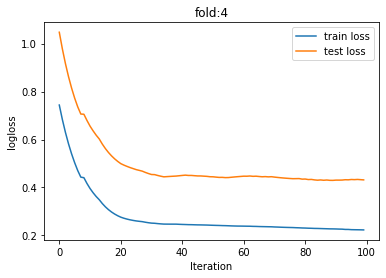

RMSE: [0.32183776746622084, 0.10165615432519115, 0.13859787158537853, 0.019684532704213328, 0.3284172854017843]
RMSE: 0.18203872229655763


In [ ]:
y_train_dropna = y_train_dropna.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_dropna["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result_dropna = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_dropna, y_train_dropna, groups)):
    X_train_gkf, X_test_gkf = X_train_dropna.iloc[train_index], X_train_dropna.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train_dropna.iloc[train_index], y_train_dropna.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  
    
    best_params = model.params

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf, num_iteration=model.best_iteration)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_dropna.append(rmse)

print("RMSE:", cv_result_dropna)
print("RMSE:", np.mean(cv_result_dropna))

## IsolationForest による外れ値除去

In [ ]:
# IsolationForest は 正常=1 異常=-1 として結果を返す
model = IsolationForest(
                random_state=SEED
                )

In [ ]:
train_anomaly = model.fit_predict(X_train_dropna)

test_anomaly = model.fit_predict(X_test_dropna)

In [ ]:
print(np.mean(abs(model.score_samples(X_train_dropna))))

0.5551405831072379

In [ ]:
X_train_normal = X_train_dropna[train_anomaly == 1]
X_train_anomaly = X_train_dropna[train_anomaly == -1]

# テスト
assert len(X_train_dropna) == (len(X_train_normal) + len(X_train_anomaly))


X_test_normal = X_test_dropna[test_anomaly == 1]
X_test_anomaly = X_test_dropna[test_anomaly == -1]

# テスト
assert len(X_test_dropna) == (len(X_test_normal) + len(X_test_anomaly))

In [ ]:
y_train_normal = y_train_dropna[train_anomaly == 1]

y_test_normal = y_test_dropna[test_anomaly == 1]

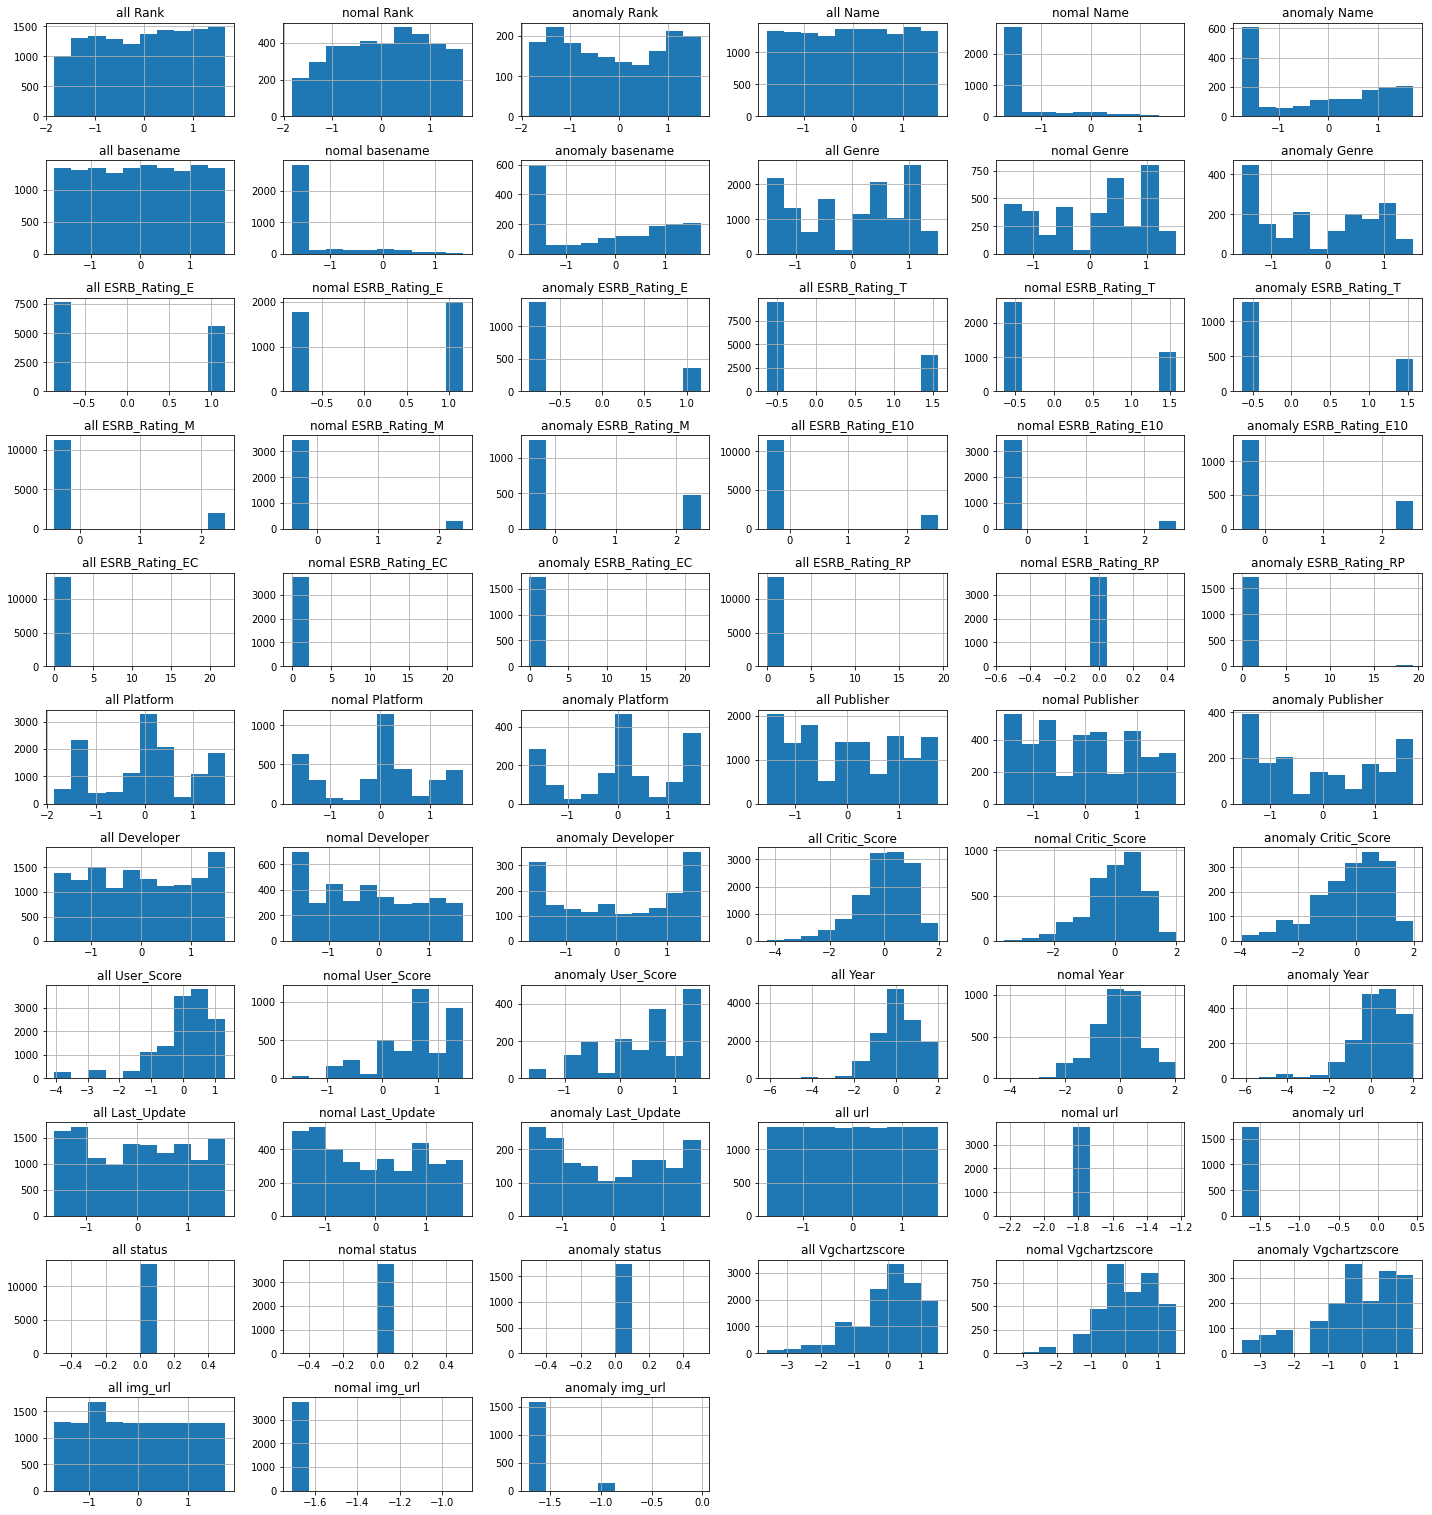

In [ ]:
plt.figure(figsize=(20, 40))
for i, column in enumerate(X_test_normal.columns):

    plt.subplot(len(X_test_dropna.columns), 6 , i*3+1)
    plt.title("all " + column)
    X_train_dropna[column].hist();

    plt.subplot(len(X_test_normal.columns), 6,  i*3+2)
    plt.title("nomal " + column)
    X_test_normal[column].hist();

    plt.subplot(len(X_test_anomaly.columns), 6 , i*3+3)
    plt.title("anomaly " + column)
    X_test_anomaly[column].hist();

plt.tight_layout()

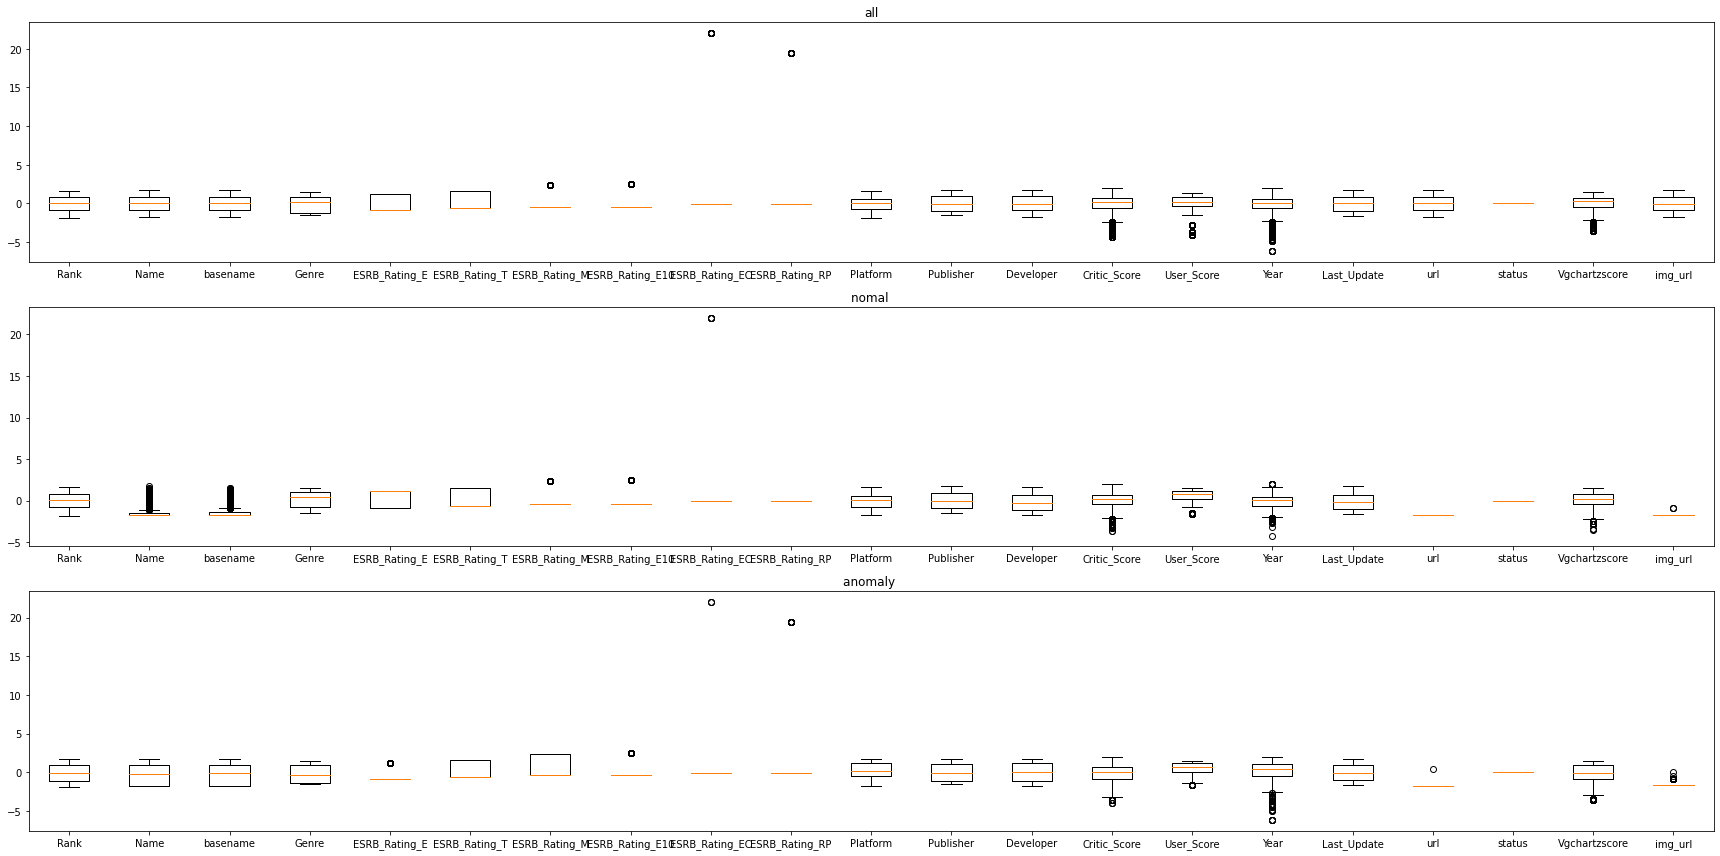

In [ ]:
plt.figure(figsize=(24, 12))

plt.subplot(3, 1 , 1)
plt.title("all")
plt.boxplot(
    X_train_dropna.values,
    labels=X_test_dropna.columns
    );

plt.subplot(3, 1 , 2)
plt.title("nomal ")
plt.boxplot(
    X_test_normal.values,
    labels=X_test_normal.columns
    );

plt.subplot(3, 1 , 3)
plt.title("anomaly ")
plt.boxplot(
    X_test_anomaly.values,
    labels=X_test_anomaly.columns
    );

plt.tight_layout()

In [ ]:
X_train_normal = X_train_normal.reset_index(drop=True)
y_train_normal = y_train_normal.reset_index(drop=True)

[I 2021-12-12 04:48:47,976] A new study created in memory with name: no-name-fd45db7c-aa4b-43c1-a300-98f2d326f83f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.211868:  14%|#4        | 1/7 [00:00<00:01,  3.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0654713	Test's rmse: 0.211868
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.211868:  29%|##8       | 2/7 [00:00<00:01,  3.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0708035	Test's rmse: 0.215416
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.207600:  43%|####2     | 3/7 [00:00<00:01,  3.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0643344	Test's rmse: 0.2076
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.202439:  57%|#####7    | 4/7 [00:01<00:01,  2.71it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0715698	Test's rmse: 0.202439
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.202439:  71%|#######1  | 5/7 [00:01<00:00,  2.84it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0661931	Test's rmse: 0.212246
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.199439:  86%|########5 | 6/7 [00:02<00:00,  2.83it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.0812003	Test's rmse: 0.199439
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.199439: 100%|##########| 7/7 [00:02<00:00,  2.84it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0670328	Test's rmse: 0.205579


num_leaves, val_score: 0.199439:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:   5%|5         | 1/20 [00:01<00:25,  1.37s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796287	Test's rmse: 0.199492
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  10%|#         | 2/20 [00:02<00:24,  1.36s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796287	Test's rmse: 0.199492
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  15%|#5        | 3/20 [00:03<00:15,  1.08it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796541	Test's rmse: 0.199489
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  20%|##        | 4/20 [00:04<00:16,  1.02s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796287	Test's rmse: 0.199492
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  25%|##5       | 5/20 [00:04<00:11,  1.30it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.0803471	Test's rmse: 0.199498
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  30%|###       | 6/20 [00:05<00:10,  1.27it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796307	Test's rmse: 0.199493
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  35%|###5      | 7/20 [00:06<00:09,  1.38it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.0799078	Test's rmse: 0.199565
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  40%|####      | 8/20 [00:07<00:09,  1.22it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796293	Test's rmse: 0.199492
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  45%|####5     | 9/20 [00:08<00:09,  1.14it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796289	Test's rmse: 0.199492
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  50%|#####     | 10/20 [00:09<00:10,  1.01s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796287	Test's rmse: 0.199492
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  55%|#####5    | 11/20 [00:09<00:07,  1.27it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.0793473	Test's rmse: 0.199622
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  60%|######    | 12/20 [00:10<00:06,  1.27it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.0804492	Test's rmse: 0.199678
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  65%|######5   | 13/20 [00:11<00:06,  1.16it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796289	Test's rmse: 0.199492
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  70%|#######   | 14/20 [00:12<00:04,  1.25it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796355	Test's rmse: 0.19949
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  75%|#######5  | 15/20 [00:12<00:03,  1.40it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.0796406	Test's rmse: 0.199491
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  80%|########  | 16/20 [00:13<00:02,  1.47it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.0798433	Test's rmse: 0.199504
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199439:  85%|########5 | 17/20 [00:14<00:02,  1.43it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.0799048	Test's rmse: 0.199566
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199277:  95%|#########5| 19/20 [00:14<00:00,  2.16it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.08019	Test's rmse: 0.199507
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866672	Test's rmse: 0.199277
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.199277: 100%|##########| 20/20 [00:14<00:00,  1.37it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866672	Test's rmse: 0.199277


bagging, val_score: 0.199277:  10%|#         | 1/10 [00:00<00:01,  8.80it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[95]	Train's rmse: 0.121844	Test's rmse: 0.236188
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.199277:  20%|##        | 2/10 [00:00<00:00,  8.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0865386	Test's rmse: 0.19958


bagging, val_score: 0.199277:  30%|###       | 3/10 [00:00<00:00,  7.31it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0865142	Test's rmse: 0.19957


bagging, val_score: 0.199277:  40%|####      | 4/10 [00:00<00:00,  7.80it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0865915	Test's rmse: 0.199715


bagging, val_score: 0.199277:  50%|#####     | 5/10 [00:00<00:00,  8.16it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.132683	Test's rmse: 0.247925


bagging, val_score: 0.199277:  60%|######    | 6/10 [00:00<00:00,  8.15it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0865844	Test's rmse: 0.19975


bagging, val_score: 0.199277:  70%|#######   | 7/10 [00:00<00:00,  8.06it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866473	Test's rmse: 0.19943


bagging, val_score: 0.199277:  80%|########  | 8/10 [00:00<00:00,  8.28it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.131971	Test's rmse: 0.248999


bagging, val_score: 0.199277:  90%|######### | 9/10 [00:01<00:00,  8.27it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112386	Test's rmse: 0.224764


bagging, val_score: 0.199277: 100%|##########| 10/10 [00:01<00:00,  8.07it/s]


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0919114	Test's rmse: 0.203845


feature_fraction_stage2, val_score: 0.199277:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.199277:  33%|###3      | 1/3 [00:00<00:00,  6.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0872551	Test's rmse: 0.199725
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0872551	Test's rmse: 0.199725


feature_fraction_stage2, val_score: 0.199277:  67%|######6   | 2/3 [00:00<00:00,  7.35it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.199277: 100%|##########| 3/3 [00:00<00:00,  7.28it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0878857	Test's rmse: 0.200114


regularization_factors, val_score: 0.199277:   5%|5         | 1/20 [00:00<00:02,  9.36it/s][I 2021-12-12 04:49:06,896] Trial 40 finished with value: 0.19927671336645433 and parameters: {'lambda_l1': 0.003097483786158401, 'lambda_l2': 4.834498487769497e-06}. Best is trial 40 with value: 0.19927671336645433.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866677	Test's rmse: 0.199277


regularization_factors, val_score: 0.199277:   5%|5         | 1/20 [00:00<00:02,  9.36it/s]

Training until validation scores don't improve for 50 rounds.

regularization_factors, val_score: 0.199277:  10%|#         | 2/20 [00:00<00:02,  8.24it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866673	Test's rmse: 0.199277
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.199277:  15%|#5        | 3/20 [00:00<00:02,  7.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866672	Test's rmse: 0.199277
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866702	Test's rmse: 0.199261


regularization_factors, val_score: 0.199261:  20%|##        | 4/20 [00:00<00:02,  7.88it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.199207:  30%|###       | 6/20 [00:00<00:01,  7.88it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866672	Test's rmse: 0.199277
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0868188	Test's rmse: 0.199207


[I 2021-12-12 04:49:07,553] Trial 45 finished with value: 0.19920741353161617 and parameters: {'lambda_l1': 0.7097067087668929, 'lambda_l2': 0.00016993599018874338}. Best is trial 45 with value: 0.19920741353161617.
regularization_factors, val_score: 0.199207:  40%|####      | 8/20 [00:01<00:01,  8.29it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866683	Test's rmse: 0.199275
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.086893	Test's rmse: 0.199325


regularization_factors, val_score: 0.199086:  50%|#####     | 10/20 [00:01<00:01,  8.42it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866804	Test's rmse: 0.199267
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0870263	Test's rmse: 0.199086


regularization_factors, val_score: 0.199086:  60%|######    | 12/20 [00:01<00:00,  8.21it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0914396	Test's rmse: 0.200521
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0887347	Test's rmse: 0.199357


regularization_factors, val_score: 0.199086:  70%|#######   | 14/20 [00:01<00:00,  8.11it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866792	Test's rmse: 0.199268
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866852	Test's rmse: 0.199286


regularization_factors, val_score: 0.199086:  80%|########  | 16/20 [00:01<00:00,  7.85it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866717	Test's rmse: 0.199264
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0868036	Test's rmse: 0.199218


regularization_factors, val_score: 0.199086:  90%|######### | 18/20 [00:02<00:00,  8.32it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866681	Test's rmse: 0.199276
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0868841	Test's rmse: 0.199165


regularization_factors, val_score: 0.199086: 100%|##########| 20/20 [00:02<00:00,  8.06it/s]


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0868611	Test's rmse: 0.199166
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0866727	Test's rmse: 0.19926


min_data_in_leaf, val_score: 0.199086:  40%|####      | 2/5 [00:00<00:00,  8.90it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0870263	Test's rmse: 0.199086
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0870263	Test's rmse: 0.199086


min_data_in_leaf, val_score: 0.199086:  80%|########  | 4/5 [00:00<00:00,  8.17it/s][I 2021-12-12 04:49:09,776] Trial 63 finished with value: 0.3059708282329551 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.19908622489041236.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0870263	Test's rmse: 0.199086
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.191799	Test's rmse: 0.305971


min_data_in_leaf, val_score: 0.199086: 100%|##########| 5/5 [00:00<00:00,  8.09it/s]


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131596	Test's rmse: 0.24699


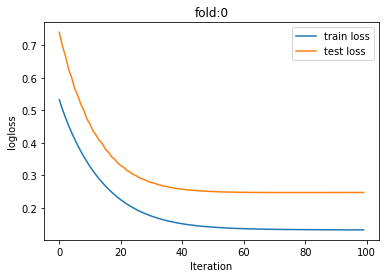

[I 2021-12-12 04:49:10,115] A new study created in memory with name: no-name-9c8c1984-ac50-4ead-8a0b-c81f7eb2a7f0
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.150689:  14%|#4        | 1/7 [00:00<00:02,  2.67it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0812745	Test's rmse: 0.150689
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.150689:  29%|##8       | 2/7 [00:00<00:01,  2.66it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0802661	Test's rmse: 0.157092
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.150689:  43%|####2     | 3/7 [00:01<00:01,  2.81it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0792773	Test's rmse: 0.162254
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.150689:  57%|#####7    | 4/7 [00:01<00:01,  2.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0774799	Test's rmse: 0.163911
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.150689:  71%|#######1  | 5/7 [00:01<00:00,  3.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0802493	Test's rmse: 0.178544
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.143152:  86%|########5 | 6/7 [00:02<00:00,  2.84it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948721	Test's rmse: 0.143152
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.143152: 100%|##########| 7/7 [00:02<00:00,  2.81it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.083563	Test's rmse: 0.148482


num_leaves, val_score: 0.143152:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:   5%|5         | 1/20 [00:00<00:11,  1.60it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948328	Test's rmse: 0.143114
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  10%|#         | 2/20 [00:01<00:15,  1.18it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948424	Test's rmse: 0.143153
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  15%|#5        | 3/20 [00:02<00:18,  1.08s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948411	Test's rmse: 0.143153
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  20%|##        | 4/20 [00:03<00:14,  1.09it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948495	Test's rmse: 0.143126
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  25%|##5       | 5/20 [00:04<00:15,  1.06s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948412	Test's rmse: 0.143153
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  30%|###       | 6/20 [00:05<00:14,  1.02s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948424	Test's rmse: 0.143121
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  35%|###5      | 7/20 [00:06<00:13,  1.02s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948424	Test's rmse: 0.143153
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  40%|####      | 8/20 [00:07<00:11,  1.07it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948495	Test's rmse: 0.143126
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  45%|####5     | 9/20 [00:08<00:08,  1.29it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948804	Test's rmse: 0.143151
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  50%|#####     | 10/20 [00:09<00:08,  1.18it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948426	Test's rmse: 0.143153
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  55%|#####5    | 11/20 [00:09<00:05,  1.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0865644	Test's rmse: 0.145644
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  60%|######    | 12/20 [00:10<00:05,  1.48it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948359	Test's rmse: 0.143121
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  65%|######5   | 13/20 [00:10<00:04,  1.50it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948447	Test's rmse: 0.143119
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  70%|#######   | 14/20 [00:11<00:03,  1.64it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948526	Test's rmse: 0.143153
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  75%|#######5  | 15/20 [00:12<00:04,  1.09it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948411	Test's rmse: 0.143153
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  80%|########  | 16/20 [00:13<00:03,  1.25it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948373	Test's rmse: 0.14312
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.143114:  85%|########5 | 17/20 [00:14<00:02,  1.22it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0948537	Test's rmse: 0.143128
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.142081:  95%|#########5| 19/20 [00:14<00:00,  1.95it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0959409	Test's rmse: 0.142081
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0908931	Test's rmse: 0.143529
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.142081: 100%|##########| 20/20 [00:15<00:00,  1.26it/s]


Early stopping, best iteration is:
[49]	Train's rmse: 0.0948414	Test's rmse: 0.143153


bagging, val_score: 0.142081:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.142081:  10%|#         | 1/10 [00:00<00:02,  3.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0922118	Test's rmse: 0.147553
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.142081:  20%|##        | 2/10 [00:00<00:02,  2.90it/s]

Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.0858483	Test's rmse: 0.146644
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.141345:  30%|###       | 3/10 [00:01<00:02,  2.99it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0943216	Test's rmse: 0.141345
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.141345:  40%|####      | 4/10 [00:01<00:01,  3.09it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0921743	Test's rmse: 0.14635
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.141345:  50%|#####     | 5/10 [00:01<00:01,  3.02it/s]

Did not meet early stopping. Best iteration is:
[95]	Train's rmse: 0.0961963	Test's rmse: 0.150532
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.141345:  60%|######    | 6/10 [00:01<00:01,  3.10it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0845662	Test's rmse: 0.143035
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.141007:  70%|#######   | 7/10 [00:02<00:00,  3.07it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.088069	Test's rmse: 0.141007
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.141007:  80%|########  | 8/10 [00:02<00:00,  3.02it/s]

Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.125343	Test's rmse: 0.194101
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.141007:  90%|######### | 9/10 [00:02<00:00,  3.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0847021	Test's rmse: 0.148686
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.141007: 100%|##########| 10/10 [00:03<00:00,  3.03it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126658	Test's rmse: 0.188489


feature_fraction_stage2, val_score: 0.141007:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.141007:  33%|###3      | 1/3 [00:00<00:00,  2.73it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0855507	Test's rmse: 0.145926
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.141007:  67%|######6   | 2/3 [00:00<00:00,  2.88it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0868969	Test's rmse: 0.142948
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.141007: 100%|##########| 3/3 [00:01<00:00,  2.83it/s]


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0868969	Test's rmse: 0.142948


regularization_factors, val_score: 0.141007:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.141007:   5%|5         | 1/20 [00:00<00:07,  2.59it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.0880691	Test's rmse: 0.141007
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.141007:  10%|#         | 2/20 [00:00<00:06,  2.80it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0871404	Test's rmse: 0.141213
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.141007:  15%|#5        | 3/20 [00:01<00:05,  2.98it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0871609	Test's rmse: 0.142681
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.141007:  20%|##        | 4/20 [00:01<00:05,  2.92it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.0880818	Test's rmse: 0.141015
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.141007:  25%|##5       | 5/20 [00:01<00:05,  2.91it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0873401	Test's rmse: 0.141986
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.141007:  30%|###       | 6/20 [00:02<00:04,  2.87it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0868937	Test's rmse: 0.143056
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.141007:  35%|###5      | 7/20 [00:02<00:04,  2.94it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0873134	Test's rmse: 0.142549
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860:  40%|####      | 8/20 [00:02<00:04,  2.97it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0877249	Test's rmse: 0.14086
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860:  45%|####5     | 9/20 [00:03<00:03,  2.92it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.088069	Test's rmse: 0.141007
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860:  50%|#####     | 10/20 [00:03<00:03,  2.89it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0874671	Test's rmse: 0.141509
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860:  55%|#####5    | 11/20 [00:03<00:02,  3.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.104166	Test's rmse: 0.153974
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860:  60%|######    | 12/20 [00:04<00:02,  3.11it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.088069	Test's rmse: 0.141007
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860:  65%|######5   | 13/20 [00:04<00:02,  3.00it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.088069	Test's rmse: 0.141007
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860:  70%|#######   | 14/20 [00:04<00:02,  2.96it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0871725	Test's rmse: 0.141751
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860:  75%|#######5  | 15/20 [00:05<00:01,  2.95it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.088069	Test's rmse: 0.141007
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860:  80%|########  | 16/20 [00:05<00:01,  3.06it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0898201	Test's rmse: 0.142814
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860:  85%|########5 | 17/20 [00:05<00:01,  2.97it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0871703	Test's rmse: 0.141751
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860:  90%|######### | 18/20 [00:06<00:00,  2.86it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.0880819	Test's rmse: 0.141015
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860:  95%|#########5| 19/20 [00:06<00:00,  2.93it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0869872	Test's rmse: 0.141855
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.140860: 100%|##########| 20/20 [00:06<00:00,  2.92it/s]


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.088069	Test's rmse: 0.141007


min_data_in_leaf, val_score: 0.140860:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.140860:  20%|##        | 1/5 [00:00<00:01,  3.15it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0586091	Test's rmse: 0.15093
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.140860:  40%|####      | 2/5 [00:00<00:01,  2.94it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.179016	Test's rmse: 0.268416
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.140860:  60%|######    | 3/5 [00:01<00:00,  2.93it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126818	Test's rmse: 0.20395
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.140860:  80%|########  | 4/5 [00:01<00:00,  3.12it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.051217	Test's rmse: 0.155633
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.140860: 100%|##########| 5/5 [00:01<00:00,  3.02it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.0932698	Test's rmse: 0.142395


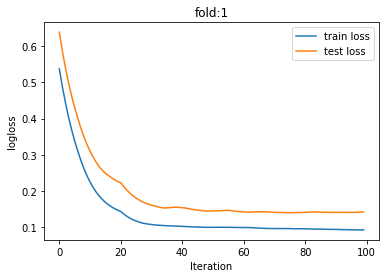

[I 2021-12-12 04:49:41,690] A new study created in memory with name: no-name-5c0fb7a3-69b5-4cb0-acb7-b7fa4548af86
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.052924:  14%|#4        | 1/7 [00:00<00:02,  2.93it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0847353	Test's rmse: 0.0529236
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.044795:  29%|##8       | 2/7 [00:00<00:01,  2.72it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0901476	Test's rmse: 0.0447952
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.044795:  43%|####2     | 3/7 [00:01<00:01,  2.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0879295	Test's rmse: 0.0486907
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.044795:  57%|#####7    | 4/7 [00:01<00:01,  2.72it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0833108	Test's rmse: 0.0635024
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.041491:  71%|#######1  | 5/7 [00:01<00:00,  2.77it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.102797	Test's rmse: 0.0414906
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.041491:  86%|########5 | 6/7 [00:02<00:00,  2.92it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0844672	Test's rmse: 0.0721209
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.041491: 100%|##########| 7/7 [00:02<00:00,  2.84it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0844168	Test's rmse: 0.0637989


num_leaves, val_score: 0.041491:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.041224:   5%|5         | 1/20 [00:00<00:13,  1.44it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.101207	Test's rmse: 0.0412236
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.041224:  10%|#         | 2/20 [00:01<00:18,  1.05s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0929908	Test's rmse: 0.0415709
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.041224:  15%|#5        | 3/20 [00:03<00:20,  1.23s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0931459	Test's rmse: 0.041668
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.041224:  20%|##        | 4/20 [00:04<00:20,  1.31s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0928441	Test's rmse: 0.0416821
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.041224:  25%|##5       | 5/20 [00:05<00:14,  1.06it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.101622	Test's rmse: 0.0414141
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.041224:  30%|###       | 6/20 [00:06<00:15,  1.14s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0928956	Test's rmse: 0.0416969
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.041224:  35%|###5      | 7/20 [00:08<00:17,  1.35s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0928574	Test's rmse: 0.0416931


num_leaves, val_score: 0.041224:  40%|####      | 8/20 [00:08<00:11,  1.03it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0951742	Test's rmse: 0.0446804
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.040868:  50%|#####     | 10/20 [00:09<00:07,  1.39it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0932101	Test's rmse: 0.0419613
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111485	Test's rmse: 0.0408685


[I 2021-12-12 04:49:53,939] Trial 16 finished with value: 0.04086847772339543 and parameters: {'num_leaves': 2}. Best is trial 16 with value: 0.04086847772339543.
num_leaves, val_score: 0.040868:  50%|#####     | 10/20 [00:09<00:07,  1.39it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.040868:  55%|#####5    | 11/20 [00:10<00:06,  1.42it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.102798	Test's rmse: 0.041372
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.040868:  60%|######    | 12/20 [00:11<00:05,  1.49it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.102974	Test's rmse: 0.0413579
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.040868:  65%|######5   | 13/20 [00:11<00:04,  1.62it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.102936	Test's rmse: 0.0414502
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.040868:  70%|#######   | 14/20 [00:12<00:04,  1.49it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.102527	Test's rmse: 0.0414591
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.040868:  75%|#######5  | 15/20 [00:12<00:03,  1.59it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.101219	Test's rmse: 0.0413565
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.040868:  80%|########  | 16/20 [00:13<00:02,  1.49it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.101204	Test's rmse: 0.0412942
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.040868:  85%|########5 | 17/20 [00:14<00:01,  1.67it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0925552	Test's rmse: 0.0413701
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.040868:  90%|######### | 18/20 [00:15<00:01,  1.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0929145	Test's rmse: 0.0415615
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.040868:  95%|#########5| 19/20 [00:15<00:00,  1.64it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0931547	Test's rmse: 0.0422702
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.040868: 100%|##########| 20/20 [00:16<00:00,  1.24it/s]


Early stopping, best iteration is:
[42]	Train's rmse: 0.102535	Test's rmse: 0.041415


bagging, val_score: 0.040868:  10%|#         | 1/10 [00:00<00:01,  7.84it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[91]	Train's rmse: 0.145987	Test's rmse: 0.0624511


bagging, val_score: 0.040868:  20%|##        | 2/10 [00:00<00:01,  7.24it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112575	Test's rmse: 0.0416583


[I 2021-12-12 04:50:00,584] Trial 28 finished with value: 0.041658254375715235 and parameters: {'bagging_fraction': 0.7246419410125282, 'bagging_freq': 3}. Best is trial 28 with value: 0.041658254375715235.
bagging, val_score: 0.040868:  30%|###       | 3/10 [00:00<00:00,  7.42it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127123	Test's rmse: 0.0501477


[I 2021-12-12 04:50:00,714] Trial 29 finished with value: 0.050147747888058106 and parameters: {'bagging_fraction': 0.6084221600530071, 'bagging_freq': 2}. Best is trial 28 with value: 0.041658254375715235.
bagging, val_score: 0.040868:  40%|####      | 4/10 [00:00<00:00,  7.37it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[95]	Train's rmse: 0.130927	Test's rmse: 0.0527941


[I 2021-12-12 04:50:00,854] Trial 30 finished with value: 0.05279405461570259 and parameters: {'bagging_fraction': 0.5968037303646416, 'bagging_freq': 7}. Best is trial 28 with value: 0.041658254375715235.
bagging, val_score: 0.040868:  40%|####      | 4/10 [00:00<00:00,  7.37it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.040868:  50%|#####     | 5/10 [00:00<00:00,  6.70it/s]

Did not meet early stopping. Best iteration is:
[91]	Train's rmse: 0.123695	Test's rmse: 0.0464391
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.040868:  60%|######    | 6/10 [00:00<00:00,  6.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114445	Test's rmse: 0.0414553


bagging, val_score: 0.040868:  70%|#######   | 7/10 [00:01<00:00,  6.91it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131016	Test's rmse: 0.0526508
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.040868:  80%|########  | 8/10 [00:01<00:00,  7.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119104	Test's rmse: 0.045049


bagging, val_score: 0.040868:  90%|######### | 9/10 [00:01<00:00,  7.16it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[92]	Train's rmse: 0.146161	Test's rmse: 0.0629004


bagging, val_score: 0.040868: 100%|##########| 10/10 [00:01<00:00,  7.06it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[92]	Train's rmse: 0.146368	Test's rmse: 0.0635924



feature_fraction_stage2, val_score: 0.040868:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.040868:  67%|######6   | 2/3 [00:00<00:00,  7.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111939	Test's rmse: 0.0427821
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111939	Test's rmse: 0.0427821


[I 2021-12-12 04:50:02,023] Trial 38 finished with value: 0.04278212966795503 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.04278212966795503.
feature_fraction_stage2, val_score: 0.040868: 100%|##########| 3/3 [00:00<00:00,  6.75it/s]


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112555	Test's rmse: 0.0446582


regularization_factors, val_score: 0.040868:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.040856:  10%|#         | 2/20 [00:00<00:02,  7.89it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111485	Test's rmse: 0.0408683
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111485	Test's rmse: 0.0408564


regularization_factors, val_score: 0.040467:  20%|##        | 4/20 [00:00<00:02,  7.31it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111485	Test's rmse: 0.0408678
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111892	Test's rmse: 0.0404666


[I 2021-12-12 04:50:02,748] Trial 43 finished with value: 0.04046658739753264 and parameters: {'lambda_l1': 2.2233430123317253, 'lambda_l2': 0.003574624728719973}. Best is trial 43 with value: 0.04046658739753264.
regularization_factors, val_score: 0.040467:  25%|##5       | 5/20 [00:00<00:02,  7.01it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111468	Test's rmse: 0.0407348
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.040467:  35%|###5      | 7/20 [00:00<00:01,  7.02it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111682	Test's rmse: 0.0417197
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111485	Test's rmse: 0.0408674


regularization_factors, val_score: 0.040467:  45%|####5     | 9/20 [00:01<00:01,  7.55it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111485	Test's rmse: 0.0408684
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111485	Test's rmse: 0.0408685


regularization_factors, val_score: 0.040446:  55%|#####5    | 11/20 [00:01<00:01,  7.55it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114113	Test's rmse: 0.0415891
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112099	Test's rmse: 0.0404455


[I 2021-12-12 04:50:03,707] Trial 50 finished with value: 0.04044554841101138 and parameters: {'lambda_l1': 3.0232219749590428, 'lambda_l2': 0.0020181645955959287}. Best is trial 50 with value: 0.04044554841101138.
regularization_factors, val_score: 0.040446:  65%|######5   | 13/20 [00:01<00:00,  7.61it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111686	Test's rmse: 0.0404559
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111518	Test's rmse: 0.040812


regularization_factors, val_score: 0.040446:  75%|#######5  | 15/20 [00:02<00:00,  7.37it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111499	Test's rmse: 0.0408541
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111513	Test's rmse: 0.0408192


[I 2021-12-12 04:50:04,249] Trial 54 finished with value: 0.04081916815750304 and parameters: {'lambda_l1': 0.204867010679305, 'lambda_l2': 0.0003857752866944335}. Best is trial 50 with value: 0.04044554841101138.
regularization_factors, val_score: 0.040446:  85%|########5 | 17/20 [00:02<00:00,  7.65it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.115253	Test's rmse: 0.0415892
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111488	Test's rmse: 0.0408627


regularization_factors, val_score: 0.040446:  95%|#########5| 19/20 [00:02<00:00,  7.53it/s][I 2021-12-12 04:50:04,764] Trial 58 finished with value: 0.040522546020476044 and parameters: {'lambda_l1': 0.848153376558071, 'lambda_l2': 0.0015378060785044192}. Best is trial 50 with value: 0.04044554841101138.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111468	Test's rmse: 0.0407875
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111622	Test's rmse: 0.0405225


regularization_factors, val_score: 0.040446: 100%|##########| 20/20 [00:02<00:00,  7.39it/s]


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111486	Test's rmse: 0.0408666


min_data_in_leaf, val_score: 0.040446:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.040446:  20%|##        | 1/5 [00:00<00:00,  5.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112099	Test's rmse: 0.0404455
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.040446:  40%|####      | 2/5 [00:00<00:00,  6.07it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146079	Test's rmse: 0.0620296


min_data_in_leaf, val_score: 0.040446:  60%|######    | 3/5 [00:00<00:00,  6.52it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112099	Test's rmse: 0.0404455


min_data_in_leaf, val_score: 0.040446:  80%|########  | 4/5 [00:00<00:00,  7.02it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112099	Test's rmse: 0.0404455


min_data_in_leaf, val_score: 0.040446: 100%|##########| 5/5 [00:00<00:00,  6.79it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.202753	Test's rmse: 0.123654


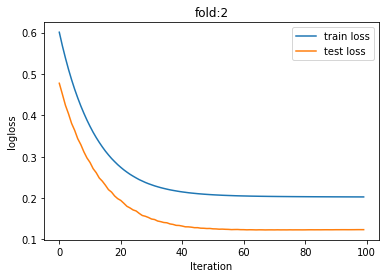

[I 2021-12-12 04:50:05,867] A new study created in memory with name: no-name-d7e601bc-2db5-41f7-94c7-22380c3762e7
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0863628	Test's rmse: 0.0919205

feature_fraction, val_score: 0.091920:  14%|#4        | 1/7 [00:00<00:01,  3.38it/s]


Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.054967:  29%|##8       | 2/7 [00:01<00:03,  1.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.093305	Test's rmse: 0.0549673
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.054967:  43%|####2     | 3/7 [00:01<00:02,  1.81it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0861993	Test's rmse: 0.0701554
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.054967:  57%|#####7    | 4/7 [00:02<00:01,  2.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0838554	Test's rmse: 0.0769931
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.054967:  71%|#######1  | 5/7 [00:02<00:00,  2.21it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0911739	Test's rmse: 0.05921
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.054967:  86%|########5 | 6/7 [00:02<00:00,  2.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0849204	Test's rmse: 0.0817453
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.054967: 100%|##########| 7/7 [00:03<00:00,  2.21it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0877273	Test's rmse: 0.0638342


num_leaves, val_score: 0.054967:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054967:   5%|5         | 1/20 [00:00<00:16,  1.15it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935382	Test's rmse: 0.0551304
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054967:  10%|#         | 2/20 [00:02<00:23,  1.33s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935125	Test's rmse: 0.0554165
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054967:  15%|#5        | 3/20 [00:04<00:23,  1.41s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0936077	Test's rmse: 0.0551837
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054967:  20%|##        | 4/20 [00:05<00:24,  1.51s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935259	Test's rmse: 0.0553402
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  25%|##5       | 5/20 [00:06<00:19,  1.30s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0933419	Test's rmse: 0.0549643
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  30%|###       | 6/20 [00:07<00:15,  1.08s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0933569	Test's rmse: 0.0552288
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  35%|###5      | 7/20 [00:08<00:16,  1.27s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0936061	Test's rmse: 0.0552122


num_leaves, val_score: 0.054964:  40%|####      | 8/20 [00:09<00:11,  1.05it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.093239	Test's rmse: 0.054991
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  45%|####5     | 9/20 [00:10<00:12,  1.10s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935669	Test's rmse: 0.0552982
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  50%|#####     | 10/20 [00:12<00:12,  1.22s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935174	Test's rmse: 0.0553788
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  55%|#####5    | 11/20 [00:13<00:10,  1.20s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.093508	Test's rmse: 0.055448
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  60%|######    | 12/20 [00:13<00:07,  1.11it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.101889	Test's rmse: 0.0552573
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  65%|######5   | 13/20 [00:13<00:05,  1.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0933993	Test's rmse: 0.055277
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  70%|#######   | 14/20 [00:15<00:05,  1.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0933613	Test's rmse: 0.0552907
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  80%|########  | 16/20 [00:16<00:02,  1.55it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0934892	Test's rmse: 0.0552794
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.103148	Test's rmse: 0.0592011
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  85%|########5 | 17/20 [00:17<00:02,  1.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935894	Test's rmse: 0.0551838
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  90%|######### | 18/20 [00:17<00:01,  1.32it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0933477	Test's rmse: 0.0550866
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964:  95%|#########5| 19/20 [00:18<00:00,  1.27it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.093478	Test's rmse: 0.0553746
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.054964: 100%|##########| 20/20 [00:20<00:00,  1.00s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0935103	Test's rmse: 0.0552669


bagging, val_score: 0.054964:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.054541:  10%|#         | 1/10 [00:01<00:08,  1.02it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0933913	Test's rmse: 0.0545414
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.054541:  20%|##        | 2/10 [00:01<00:06,  1.16it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.104887	Test's rmse: 0.0551739
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.054541:  30%|###       | 3/10 [00:02<00:06,  1.07it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.118294	Test's rmse: 0.0695582
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.053821:  40%|####      | 4/10 [00:03<00:05,  1.00it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0931758	Test's rmse: 0.0538207
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.049909:  50%|#####     | 5/10 [00:04<00:04,  1.06it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.107002	Test's rmse: 0.0499092
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.049909:  60%|######    | 6/10 [00:05<00:03,  1.10it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.107026	Test's rmse: 0.05184
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.049909:  70%|#######   | 7/10 [00:06<00:02,  1.08it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.118803	Test's rmse: 0.0778893
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.049909:  80%|########  | 8/10 [00:07<00:01,  1.14it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.143392	Test's rmse: 0.0859304
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.049909:  90%|######### | 9/10 [00:08<00:00,  1.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123904	Test's rmse: 0.076801
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.049909: 100%|##########| 10/10 [00:09<00:00,  1.09it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.104486	Test's rmse: 0.0526037


feature_fraction_stage2, val_score: 0.049909:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.049909:  33%|###3      | 1/3 [00:01<00:02,  1.03s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0965853	Test's rmse: 0.0593153
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.049909:  67%|######6   | 2/3 [00:02<00:01,  1.02s/it]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0959742	Test's rmse: 0.0628985
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.049909: 100%|##########| 3/3 [00:03<00:00,  1.03s/it]


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.0965853	Test's rmse: 0.0593153


regularization_factors, val_score: 0.049909:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:   5%|5         | 1/20 [00:00<00:11,  1.66it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.106969	Test's rmse: 0.0490488
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  10%|#         | 2/20 [00:00<00:08,  2.20it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.107301	Test's rmse: 0.050727
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  15%|#5        | 3/20 [00:01<00:10,  1.55it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.106998	Test's rmse: 0.0499123
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  20%|##        | 4/20 [00:02<00:11,  1.45it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.10701	Test's rmse: 0.049181
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  25%|##5       | 5/20 [00:03<00:10,  1.42it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.104671	Test's rmse: 0.0501021
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  30%|###       | 6/20 [00:04<00:10,  1.38it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.112415	Test's rmse: 0.049981
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  35%|###5      | 7/20 [00:04<00:09,  1.31it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.107002	Test's rmse: 0.0499092
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  40%|####      | 8/20 [00:05<00:09,  1.32it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.106892	Test's rmse: 0.0496493
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  45%|####5     | 9/20 [00:06<00:08,  1.35it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.105863	Test's rmse: 0.0495148
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  50%|#####     | 10/20 [00:06<00:06,  1.65it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.104947	Test's rmse: 0.0498159
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  55%|#####5    | 11/20 [00:07<00:05,  1.71it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.112446	Test's rmse: 0.050006
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  60%|######    | 12/20 [00:07<00:04,  1.65it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.104963	Test's rmse: 0.0494269
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  65%|######5   | 13/20 [00:08<00:04,  1.57it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.106994	Test's rmse: 0.0496246
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  70%|#######   | 14/20 [00:09<00:04,  1.49it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.112418	Test's rmse: 0.0499865
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  75%|#######5  | 15/20 [00:09<00:02,  1.85it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108829	Test's rmse: 0.0564606
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  80%|########  | 16/20 [00:10<00:02,  1.65it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.107048	Test's rmse: 0.0491015
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  85%|########5 | 17/20 [00:11<00:01,  1.54it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.112417	Test's rmse: 0.0499867
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.049049:  90%|######### | 18/20 [00:11<00:01,  1.73it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.112311	Test's rmse: 0.0499258
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.048985:  95%|#########5| 19/20 [00:12<00:00,  1.56it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.104819	Test's rmse: 0.0489846
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.048985: 100%|##########| 20/20 [00:12<00:00,  1.54it/s]


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.100244	Test's rmse: 0.055958


min_data_in_leaf, val_score: 0.048985:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.048985:  20%|##        | 1/5 [00:00<00:02,  1.60it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.143036	Test's rmse: 0.0879566
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.048985:  40%|####      | 2/5 [00:01<00:02,  1.42it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.0940768	Test's rmse: 0.05873
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.048985:  60%|######    | 3/5 [00:01<00:01,  1.68it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.218516	Test's rmse: 0.158785
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.048985:  80%|########  | 4/5 [00:02<00:00,  1.58it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.0745816	Test's rmse: 0.0574055
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.048985: 100%|##########| 5/5 [00:03<00:00,  1.55it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.166541	Test's rmse: 0.107285


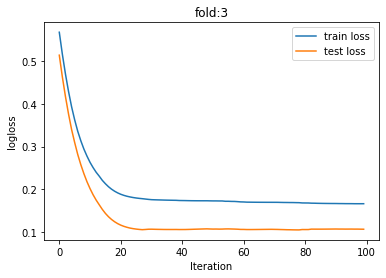

[I 2021-12-12 04:50:57,900] A new study created in memory with name: no-name-6c9f533b-c22f-4e50-99fa-3db483e847d2
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.070903:  14%|#4        | 1/7 [00:00<00:02,  2.86it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0863331	Test's rmse: 0.0709033
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.070903:  29%|##8       | 2/7 [00:00<00:01,  2.98it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0875386	Test's rmse: 0.0806234
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.070903:  43%|####2     | 3/7 [00:01<00:01,  2.90it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0844331	Test's rmse: 0.0758314
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.063123:  57%|#####7    | 4/7 [00:01<00:01,  2.86it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.110161	Test's rmse: 0.0631231
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.063123:  71%|#######1  | 5/7 [00:01<00:00,  2.89it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.113205	Test's rmse: 0.0682364
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.063123:  86%|########5 | 6/7 [00:02<00:00,  2.86it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0862402	Test's rmse: 0.0774524
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.058897: 100%|##########| 7/7 [00:02<00:00,  2.87it/s]


Early stopping, best iteration is:
[27]	Train's rmse: 0.112621	Test's rmse: 0.0588968


num_leaves, val_score: 0.058897:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058897:   5%|5         | 1/20 [00:00<00:14,  1.34it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.111967	Test's rmse: 0.0594288
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058897:  10%|#         | 2/20 [00:01<00:14,  1.25it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.111966	Test's rmse: 0.0594333
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058886:  15%|#5        | 3/20 [00:01<00:10,  1.63it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.112105	Test's rmse: 0.0588859
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058886:  20%|##        | 4/20 [00:02<00:11,  1.34it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.111966	Test's rmse: 0.0594337
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058886:  25%|##5       | 5/20 [00:03<00:09,  1.59it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.112072	Test's rmse: 0.0599287
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058886:  30%|###       | 6/20 [00:04<00:10,  1.34it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.111966	Test's rmse: 0.0594334
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058886:  35%|###5      | 7/20 [00:04<00:07,  1.75it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.110819	Test's rmse: 0.0606374
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058886:  40%|####      | 8/20 [00:05<00:09,  1.31it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.111966	Test's rmse: 0.0594338
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058886:  45%|####5     | 9/20 [00:06<00:08,  1.27it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.111966	Test's rmse: 0.0594336
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058886:  50%|#####     | 10/20 [00:07<00:08,  1.19it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.111966	Test's rmse: 0.0594333
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058886:  55%|#####5    | 11/20 [00:08<00:06,  1.32it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.11197	Test's rmse: 0.0594272
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058886:  60%|######    | 12/20 [00:08<00:05,  1.44it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.11197	Test's rmse: 0.0594247
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058886:  65%|######5   | 13/20 [00:09<00:04,  1.50it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.11197	Test's rmse: 0.0594255
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058876:  70%|#######   | 14/20 [00:09<00:03,  1.85it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.112272	Test's rmse: 0.0588759
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058876:  75%|#######5  | 15/20 [00:09<00:02,  2.22it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.112272	Test's rmse: 0.0588759
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058876:  85%|########5 | 17/20 [00:10<00:00,  3.24it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.110819	Test's rmse: 0.0606374
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11215	Test's rmse: 0.0667416
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058876:  90%|######### | 18/20 [00:10<00:00,  2.35it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.111967	Test's rmse: 0.0594268
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058876:  95%|#########5| 19/20 [00:11<00:00,  2.38it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.11202	Test's rmse: 0.0594257
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.058876: 100%|##########| 20/20 [00:12<00:00,  1.62it/s]


Early stopping, best iteration is:
[27]	Train's rmse: 0.111966	Test's rmse: 0.0594339


bagging, val_score: 0.058876:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[38]	Train's rmse: 0.14688	Test's rmse: 0.0578912


bagging, val_score: 0.057891:  10%|#         | 1/10 [00:00<00:02,  3.36it/s]

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[29]	Train's rmse: 0.119449	Test's rmse: 0.0552119


bagging, val_score: 0.055212:  20%|##        | 2/10 [00:00<00:02,  3.44it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.055212:  30%|###       | 3/10 [00:00<00:01,  3.59it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.112337	Test's rmse: 0.0569636
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.055212:  40%|####      | 4/10 [00:01<00:01,  3.59it/s][I 2021-12-12 04:51:13,872] Trial 30 finished with value: 0.060387414698599 and parameters: {'bagging_fraction': 0.8697390891753369, 'bagging_freq': 4}. Best is trial 28 with value: 0.055211901222112926.


Early stopping, best iteration is:
[24]	Train's rmse: 0.11927	Test's rmse: 0.0603874


bagging, val_score: 0.055212:  40%|####      | 4/10 [00:01<00:01,  3.59it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.055212:  50%|#####     | 5/10 [00:01<00:01,  3.68it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.139458	Test's rmse: 0.058109
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.055212:  60%|######    | 6/10 [00:01<00:01,  3.52it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.141784	Test's rmse: 0.0637327
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.055212:  70%|#######   | 7/10 [00:01<00:00,  3.59it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.147351	Test's rmse: 0.057278
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.055212:  80%|########  | 8/10 [00:02<00:00,  3.60it/s]

Early stopping, best iteration is:
[25]	Train's rmse: 0.117122	Test's rmse: 0.0610275
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.055212:  90%|######### | 9/10 [00:02<00:00,  3.58it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.126207	Test's rmse: 0.0552542
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.055212: 100%|##########| 10/10 [00:02<00:00,  3.52it/s]


Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.121864	Test's rmse: 0.0600747


feature_fraction_stage2, val_score: 0.055212:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.055212:  33%|###3      | 1/3 [00:00<00:00,  3.10it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.114122	Test's rmse: 0.0625304
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.055212:  67%|######6   | 2/3 [00:00<00:00,  3.43it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.122104	Test's rmse: 0.0615405
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.055212: 100%|##########| 3/3 [00:00<00:00,  3.30it/s]


Early stopping, best iteration is:
[29]	Train's rmse: 0.122104	Test's rmse: 0.0615405


regularization_factors, val_score: 0.055212:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.055212:   5%|5         | 1/20 [00:00<00:06,  3.05it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.119431	Test's rmse: 0.0557987
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.055212:  10%|#         | 2/20 [00:00<00:05,  3.45it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.118333	Test's rmse: 0.0564209
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.055125:  15%|#5        | 3/20 [00:00<00:04,  3.51it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.118292	Test's rmse: 0.0551255
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.055125:  20%|##        | 4/20 [00:01<00:04,  3.59it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.11945	Test's rmse: 0.0552122
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.055125:  25%|##5       | 5/20 [00:01<00:04,  3.72it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.121789	Test's rmse: 0.0558689
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.055125:  30%|###       | 6/20 [00:01<00:03,  3.75it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.11945	Test's rmse: 0.0552119
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.054599:  35%|###5      | 7/20 [00:01<00:03,  3.67it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.124011	Test's rmse: 0.0545987
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.054599:  40%|####      | 8/20 [00:02<00:03,  3.72it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.11945	Test's rmse: 0.0552118
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.052499:  45%|####5     | 9/20 [00:02<00:02,  3.91it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.126887	Test's rmse: 0.0524994
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.052499:  50%|#####     | 10/20 [00:02<00:02,  3.83it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.119455	Test's rmse: 0.0552105
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.052499:  55%|#####5    | 11/20 [00:02<00:02,  3.81it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.124062	Test's rmse: 0.0545557
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.052499:  60%|######    | 12/20 [00:03<00:02,  3.90it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.122066	Test's rmse: 0.0562221
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.052499:  65%|######5   | 13/20 [00:03<00:01,  3.92it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.126984	Test's rmse: 0.0526321
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.052499:  70%|#######   | 14/20 [00:03<00:01,  3.91it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.118915	Test's rmse: 0.0553371
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.052499:  75%|#######5  | 15/20 [00:04<00:01,  3.85it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.121203	Test's rmse: 0.0563225
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.052499:  80%|########  | 16/20 [00:04<00:01,  4.00it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.12661	Test's rmse: 0.0550774
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.052499:  85%|########5 | 17/20 [00:04<00:00,  3.96it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.119187	Test's rmse: 0.0553597
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.052499:  90%|######### | 18/20 [00:04<00:00,  4.02it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.121899	Test's rmse: 0.0579965
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.052499:  95%|#########5| 19/20 [00:04<00:00,  4.02it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.118546	Test's rmse: 0.0548553
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.052499: 100%|##########| 20/20 [00:05<00:00,  3.82it/s]


Early stopping, best iteration is:
[27]	Train's rmse: 0.12408	Test's rmse: 0.0603359


min_data_in_leaf, val_score: 0.052499:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.052499:  20%|##        | 1/5 [00:00<00:01,  3.33it/s]

Did not meet early stopping. Best iteration is:
[92]	Train's rmse: 0.171074	Test's rmse: 0.0862359
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.052499:  40%|####      | 2/5 [00:00<00:00,  3.76it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.120027	Test's rmse: 0.0553147
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.052499:  60%|######    | 3/5 [00:00<00:00,  3.63it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.222506	Test's rmse: 0.132836
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.051727:  80%|########  | 4/5 [00:01<00:00,  3.86it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.122564	Test's rmse: 0.0517266
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.051727: 100%|##########| 5/5 [00:01<00:00,  3.76it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.145704	Test's rmse: 0.0650269


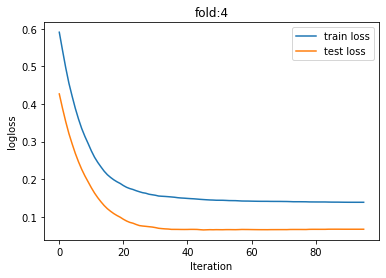

RMSE: [0.19908621568222945, 0.1408598029907364, 0.040445552288314285, 0.04898461065694658, 0.051726601686069726]
RMSE: 0.09622055666085928


In [ ]:
gkf = GroupKFold(n_splits=5)

groups = X_train_normal["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 多クラス分類を指定
          'metric': 'rmse',  # 多クラス分類の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result_rm_out = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_normal, y_train_normal, groups)):
    X_train_gkf, X_test_gkf = X_train_normal.iloc[train_index], X_train_normal.iloc[test_index]
    y_train_gkf, y_test_gkf =  y_train_normal.iloc[train_index],  y_train_normal.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  
    
    best_params = model.params

   # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf, num_iteration=model.best_iteration)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_rm_out.append(rmse)

print("RMSE:", cv_result_rm_out)
print("RMSE:", np.mean(cv_result_rm_out))

In [ ]:
print("RMSE:", round(np.mean(cv_result_dropna), 3))
print("外れ値除去 RMSE:", round(np.mean(cv_result_rm_out), 3))

RMSE: 0.182
外れ値除去 RMSE: 0.096
